<div style="background-image: url('https://images.unsplash.com/photo-1506905925346-21bda4d32df4?w=1200');
            background-size: cover;
            background-position: center;
            height: 200px;
            border-radius: 15px;
            display: flex;
            align-items: center;
            justify-content: center;
            position: relative;">
    <div style="background: rgba(0,0,0,0.3); 
                padding: 20px; 
                border-radius: 10px; 
                color: white;
                text-align: center;">
        <h1 style="margin: 0;">1. Feature Engineering</h1>
    </div>
</div>


## Imports

In [15]:
import matplotlib.pyplot as plt 
import pandas as pd
import holidays
import seaborn as sns
import warnings
import optuna
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error, mean_squared_error
from sklearn import metrics
import xgboost as xgb
import numpy as np 
import category_encoders as ce
from sklearn.model_selection import TimeSeriesSplit
import missingno as msno 
import shap

warnings.filterwarnings("ignore")


In [16]:
weather = pd.read_csv('../ect/weather_completed.csv')
weather

station                       time   no2    o3  pm25  \
0        Belfast Centre  2022-07-17 00:00:00+00:00  14.0  43.0   7.0   
1        Belfast Centre  2022-07-17 01:00:00+00:00  16.0  40.0   7.0   
2        Belfast Centre  2022-07-17 02:00:00+00:00  17.0  39.0   7.0   
3        Belfast Centre  2022-07-17 03:00:00+00:00  17.0  39.0   7.0   
4        Belfast Centre  2022-07-17 04:00:00+00:00   9.0  40.0   7.0   
...                 ...                        ...   ...   ...   ...   
1289950    York Bootham  2025-07-15 11:00:00+00:00   NaN  38.0   NaN   
1289951    York Bootham  2025-07-15 12:00:00+00:00   NaN  38.0   NaN   
1289952    York Bootham  2025-07-15 13:00:00+00:00   NaN  35.0   NaN   
1289953    York Bootham  2025-07-15 14:00:00+00:00   NaN  35.0   NaN   
1289954    York Bootham  2025-07-15 16:00:00+00:00   NaN  32.0   NaN   

         wind_speed_10m  wind_direction_10m  temperature_2m  \
0              5.154415          114.775116       14.488000   
1              4.680000          112.619910       13.938001   
2              6.439876          153.435010       14.438001   
3              7.172949          197.525670       14.888001   
4              5.623380          140.194470       14.888001   
...                 ...                 ...             ...   
1289950       15.137133          177.273740       16.161001   
1289951       18.643690          169.992080       16.811000   
1289952       22.528780          172.193700       15.361000   
1289953       24.332644          177.031830       15.111000   
1289954       21.869816          185.194340       17.261000   

         relative_humidity_2m  precipitation  rain  surface_pressure  \
0                   86.647680            0.0   0.0        1019.81600   
1                   84.056150            0.0   0.0        1019.50710   
2                   78.723180            0.0   0.0        1019.61600   
3                   77.751450            1.1   1.1        1019.72420   
4                   81.976660            1.3   1.3        1019.02790   
...                       ...            ...   ...               ...   
1289950             80.542470            1.1   1.1        1008.41260   
1289951             76.275190            0.3   0.3        1008.01746   
1289952             92.257970            1.6   1.6        1008.10810   
1289953             91.052956            1.0   1.0        1007.70720   
1289954             78.876480            0.1   0.1        1006.42285   

         pressure_msl  shortwave_radiation  
0              1025.4                  0.0  
1              1025.1                  0.0  
2              1025.2                  0.0  
3              1025.3                  0.0  
4              1024.6                  0.0  
...               ...                  ...  
1289950        1010.2                188.0  
1289951        1009.8                137.0  
1289952        1009.9                164.0  
1289953        1009.5                 98.0  
1289954        1008.2                414.0  

[1289955 rows x 14 columns]

The idea here is that there may be a drop in polution during holidays, for example during christmas there will be less traffic implying there will be a drop in polution, by indicating to the model that a certain day is a holiday may increase the performance. 

In [17]:
uk_holi = holidays.country_holidays('GB', years=[2022, 2023, 2024, 2025])
holiday_dates = set(uk_holi)
holiday_dates


{datetime.date(2022, 1, 1),
 datetime.date(2022, 1, 3),
 datetime.date(2022, 4, 15),
 datetime.date(2022, 5, 2),
 datetime.date(2022, 6, 2),
 datetime.date(2022, 6, 3),
 datetime.date(2022, 9, 19),
 datetime.date(2022, 12, 25),
 datetime.date(2022, 12, 26),
 datetime.date(2022, 12, 27),
 datetime.date(2023, 1, 1),
 datetime.date(2023, 1, 2),
 datetime.date(2023, 4, 7),
 datetime.date(2023, 5, 1),
 datetime.date(2023, 5, 8),
 datetime.date(2023, 5, 29),
 datetime.date(2023, 12, 25),
 datetime.date(2023, 12, 26),
 datetime.date(2024, 1, 1),
 datetime.date(2024, 3, 29),
 datetime.date(2024, 5, 6),
 datetime.date(2024, 5, 27),
 datetime.date(2024, 12, 25),
 datetime.date(2024, 12, 26),
 datetime.date(2025, 1, 1),
 datetime.date(2025, 4, 18),
 datetime.date(2025, 5, 5),
 datetime.date(2025, 5, 26),
 datetime.date(2025, 12, 25),
 datetime.date(2025, 12, 26)}

In [18]:
weather['is_holiday'] = 0
weather

station                       time   no2    o3  pm25  \
0        Belfast Centre  2022-07-17 00:00:00+00:00  14.0  43.0   7.0   
1        Belfast Centre  2022-07-17 01:00:00+00:00  16.0  40.0   7.0   
2        Belfast Centre  2022-07-17 02:00:00+00:00  17.0  39.0   7.0   
3        Belfast Centre  2022-07-17 03:00:00+00:00  17.0  39.0   7.0   
4        Belfast Centre  2022-07-17 04:00:00+00:00   9.0  40.0   7.0   
...                 ...                        ...   ...   ...   ...   
1289950    York Bootham  2025-07-15 11:00:00+00:00   NaN  38.0   NaN   
1289951    York Bootham  2025-07-15 12:00:00+00:00   NaN  38.0   NaN   
1289952    York Bootham  2025-07-15 13:00:00+00:00   NaN  35.0   NaN   
1289953    York Bootham  2025-07-15 14:00:00+00:00   NaN  35.0   NaN   
1289954    York Bootham  2025-07-15 16:00:00+00:00   NaN  32.0   NaN   

         wind_speed_10m  wind_direction_10m  temperature_2m  \
0              5.154415          114.775116       14.488000   
1              4.680000          112.619910       13.938001   
2              6.439876          153.435010       14.438001   
3              7.172949          197.525670       14.888001   
4              5.623380          140.194470       14.888001   
...                 ...                 ...             ...   
1289950       15.137133          177.273740       16.161001   
1289951       18.643690          169.992080       16.811000   
1289952       22.528780          172.193700       15.361000   
1289953       24.332644          177.031830       15.111000   
1289954       21.869816          185.194340       17.261000   

         relative_humidity_2m  precipitation  rain  surface_pressure  \
0                   86.647680            0.0   0.0        1019.81600   
1                   84.056150            0.0   0.0        1019.50710   
2                   78.723180            0.0   0.0        1019.61600   
3                   77.751450            1.1   1.1        1019.72420   
4                   81.976660            1.3   1.3        1019.02790   
...                       ...            ...   ...               ...   
1289950             80.542470            1.1   1.1        1008.41260   
1289951             76.275190            0.3   0.3        1008.01746   
1289952             92.257970            1.6   1.6        1008.10810   
1289953             91.052956            1.0   1.0        1007.70720   
1289954             78.876480            0.1   0.1        1006.42285   

         pressure_msl  shortwave_radiation  is_holiday  
0              1025.4                  0.0           0  
1              1025.1                  0.0           0  
2              1025.2                  0.0           0  
3              1025.3                  0.0           0  
4              1024.6                  0.0           0  
...               ...                  ...         ...  
1289950        1010.2                188.0           0  
1289951        1009.8                137.0           0  
1289952        1009.9                164.0           0  
1289953        1009.5                 98.0           0  
1289954        1008.2                414.0           0  

[1289955 rows x 15 columns]

In [19]:
weather['time'] = pd.to_datetime(weather['time'])

In [20]:
weather['is_holiday'] = weather['time'].dt.date.isin(holiday_dates).astype(int)
weather


station                      time   no2    o3  pm25  \
0        Belfast Centre 2022-07-17 00:00:00+00:00  14.0  43.0   7.0   
1        Belfast Centre 2022-07-17 01:00:00+00:00  16.0  40.0   7.0   
2        Belfast Centre 2022-07-17 02:00:00+00:00  17.0  39.0   7.0   
3        Belfast Centre 2022-07-17 03:00:00+00:00  17.0  39.0   7.0   
4        Belfast Centre 2022-07-17 04:00:00+00:00   9.0  40.0   7.0   
...                 ...                       ...   ...   ...   ...   
1289950    York Bootham 2025-07-15 11:00:00+00:00   NaN  38.0   NaN   
1289951    York Bootham 2025-07-15 12:00:00+00:00   NaN  38.0   NaN   
1289952    York Bootham 2025-07-15 13:00:00+00:00   NaN  35.0   NaN   
1289953    York Bootham 2025-07-15 14:00:00+00:00   NaN  35.0   NaN   
1289954    York Bootham 2025-07-15 16:00:00+00:00   NaN  32.0   NaN   

         wind_speed_10m  wind_direction_10m  temperature_2m  \
0              5.154415          114.775116       14.488000   
1              4.680000          112.619910       13.938001   
2              6.439876          153.435010       14.438001   
3              7.172949          197.525670       14.888001   
4              5.623380          140.194470       14.888001   
...                 ...                 ...             ...   
1289950       15.137133          177.273740       16.161001   
1289951       18.643690          169.992080       16.811000   
1289952       22.528780          172.193700       15.361000   
1289953       24.332644          177.031830       15.111000   
1289954       21.869816          185.194340       17.261000   

         relative_humidity_2m  precipitation  rain  surface_pressure  \
0                   86.647680            0.0   0.0        1019.81600   
1                   84.056150            0.0   0.0        1019.50710   
2                   78.723180            0.0   0.0        1019.61600   
3                   77.751450            1.1   1.1        1019.72420   
4                   81.976660            1.3   1.3        1019.02790   
...                       ...            ...   ...               ...   
1289950             80.542470            1.1   1.1        1008.41260   
1289951             76.275190            0.3   0.3        1008.01746   
1289952             92.257970            1.6   1.6        1008.10810   
1289953             91.052956            1.0   1.0        1007.70720   
1289954             78.876480            0.1   0.1        1006.42285   

         pressure_msl  shortwave_radiation  is_holiday  
0              1025.4                  0.0           0  
1              1025.1                  0.0           0  
2              1025.2                  0.0           0  
3              1025.3                  0.0           0  
4              1024.6                  0.0           0  
...               ...                  ...         ...  
1289950        1010.2                188.0           0  
1289951        1009.8                137.0           0  
1289952        1009.9                164.0           0  
1289953        1009.5                 98.0           0  
1289954        1008.2                414.0           0  

[1289955 rows x 15 columns]

In [21]:
weather['date'] = pd.to_datetime(weather['time']).dt.date
daily_max = weather.groupby(['station', 'date'])['wind_speed_10m'].max().sort_values(ascending=False).head(5)
daily_max

station                date      
Narberth               2024-12-07    69.465310
Charlton Mackrell      2024-12-07    62.429640
Brighton Preston Park  2023-11-02    62.059025
Blackpool Marton       2023-11-13    61.263493
Brighton Preston Park  2022-11-01    60.753666
Name: wind_speed_10m, dtype: float64

In [22]:
top_5 = daily_max.reset_index()['station'].tolist()
top_5_date = daily_max.reset_index()['date'].tolist()
top_5_date

[datetime.date(2024, 12, 7),
 datetime.date(2024, 12, 7),
 datetime.date(2023, 11, 2),
 datetime.date(2023, 11, 13),
 datetime.date(2022, 11, 1)]

In [23]:
top_5

['Narberth',
 'Charlton Mackrell',
 'Brighton Preston Park',
 'Blackpool Marton',
 'Brighton Preston Park']

Text(0, 0.5, 'KM/H')

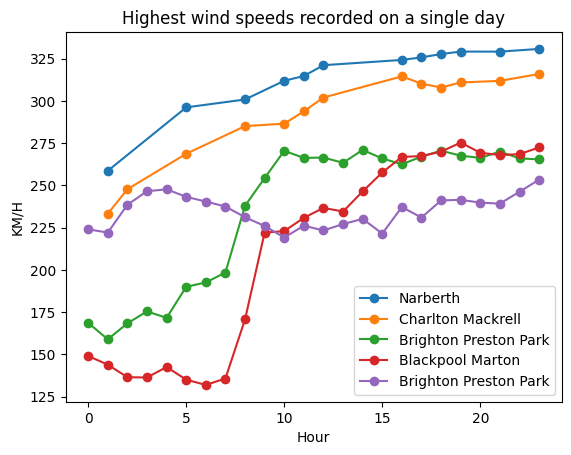

In [24]:
for m, k in enumerate(top_5):
    a = weather[weather['station']==k]
    a = a[a['date']==top_5_date[m]]
    a['hour'] = pd.to_datetime(a['time']).dt.hour
    plt.plot(a['hour'], a['wind_direction_10m'], 'o-',label=k, )
plt.title('Highest wind speeds recorded on a single day')
plt.legend(top_5)
plt.xlabel('Hour')
plt.ylabel('KM/H')

    # plt.scatter()

The temperature seems to reach it's maximum around noon, eventually it plateus. This makes sense because as the sun heats the ground during the morning, the warm air eventually rises to the surface. This causes the air to mix with the faster moving winds, and bringing the faster wind down. 

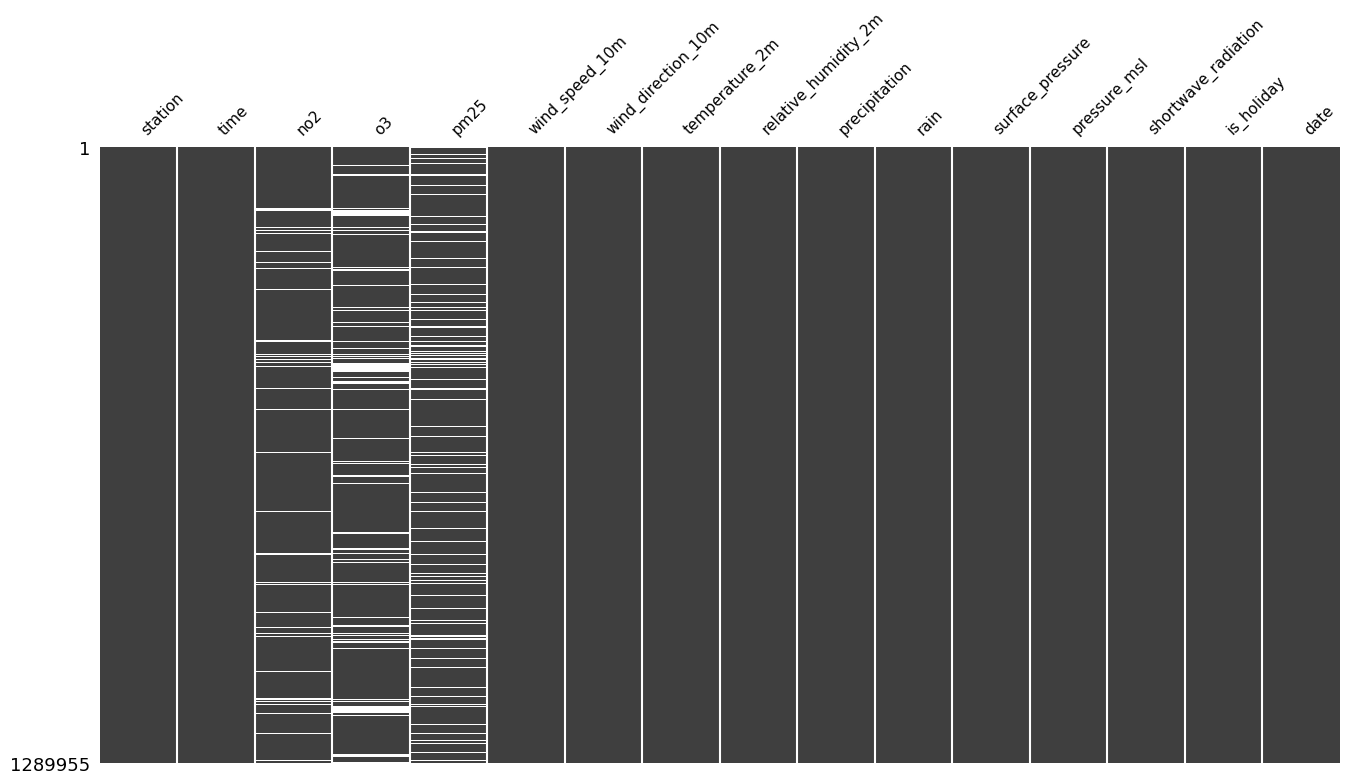

In [25]:
msno.matrix(weather, sparkline=False, figsize=(16,8), fontsize=11, filter='bottom');

In [26]:

averaged_pm = weather.groupby([weather['time'].dt.date, 'station'])['pm25'].mean()
daily_pm25 = averaged_pm.unstack(level='station')
daily_pm25

station     Belfast Centre  Bexley - Belvedere West  \
time                                                  
2022-07-17        8.000000                 7.709091   
2022-07-18        9.791667                10.581818   
2022-07-19        8.833333                14.100000   
2022-07-20        5.277778                14.304545   
2022-07-21        4.166667                 6.731818   
...                    ...                      ...   
2025-07-11        5.826087                 5.545833   
2025-07-12       10.260870                 7.775000   
2025-07-13        5.913043                 6.216667   
2025-07-14        6.173913                      NaN   
2025-07-15        3.789474                      NaN   

station     Bexley - Slade Green Fidas  Birmingham A4540 Roadside  \
time                                                                
2022-07-17                    4.862500                  10.375000   
2022-07-18                    9.437500                   8.750000   
2022-07-19                   11.791667                  10.583333   
2022-07-20                   17.225000                  14.277778   
2022-07-21                    9.808333                   6.750000   
...                                ...                        ...   
2025-07-11                    5.545833                   6.043478   
2025-07-12                    5.888889                   4.826087   
2025-07-13                         NaN                   4.826087   
2025-07-14                         NaN                   7.608696   
2025-07-15                         NaN                   5.043478   

station     Blackpool Marton  Bournemouth  Brent - Ikea  \
time                                                      
2022-07-17          7.458333     7.916667     11.380952   
2022-07-18          8.416667     8.041667     14.590909   
2022-07-19          9.958333    11.666667     21.545455   
2022-07-20          8.722222    13.166667     17.571429   
2022-07-21          3.625000     7.625000     10.590909   
...                      ...          ...           ...   
2025-07-11          5.000000     6.041667     12.416667   
2025-07-12          4.695652     5.708333     11.416667   
2025-07-13          4.391304     5.733333      8.800000   
2025-07-14          7.739130          NaN           NaN   
2025-07-15          6.000000          NaN           NaN   

station     Brighton Preston Park  Bristol St Paul's  Camden - Bloomsbury  \
time                                                                        
2022-07-17               7.083333                NaN             4.875000   
2022-07-18               9.958333                NaN             8.833333   
2022-07-19              12.125000                NaN             9.833333   
2022-07-20              14.944444                NaN            17.500000   
2022-07-21              11.166667                NaN             9.875000   
...                           ...                ...                  ...   
2025-07-11               4.782609           6.826087             5.004167   
2025-07-12               3.047619           6.521739             5.842105   
2025-07-13               4.312500           6.130435                  NaN   
2025-07-14               8.217391           5.666667                  NaN   
2025-07-15               7.217391                NaN                  NaN   

station     ...   St Osyth  Stoke-on-Trent Centre  Sunderland Silksworth  \
time        ...                                                            
2022-07-17  ...   3.857143              10.208333                    NaN   
2022-07-18  ...   7.428571               7.333333                    NaN   
2022-07-19  ...  10.200000              10.208333                    NaN   
2022-07-20  ...  15.888889              14.055556                    NaN   
2022-07-21  ...   9.125000               6.750000                    NaN   
...         ...        ...                    ...                    ...   
2025-07-

Text(0, 0.5, 'Stations')

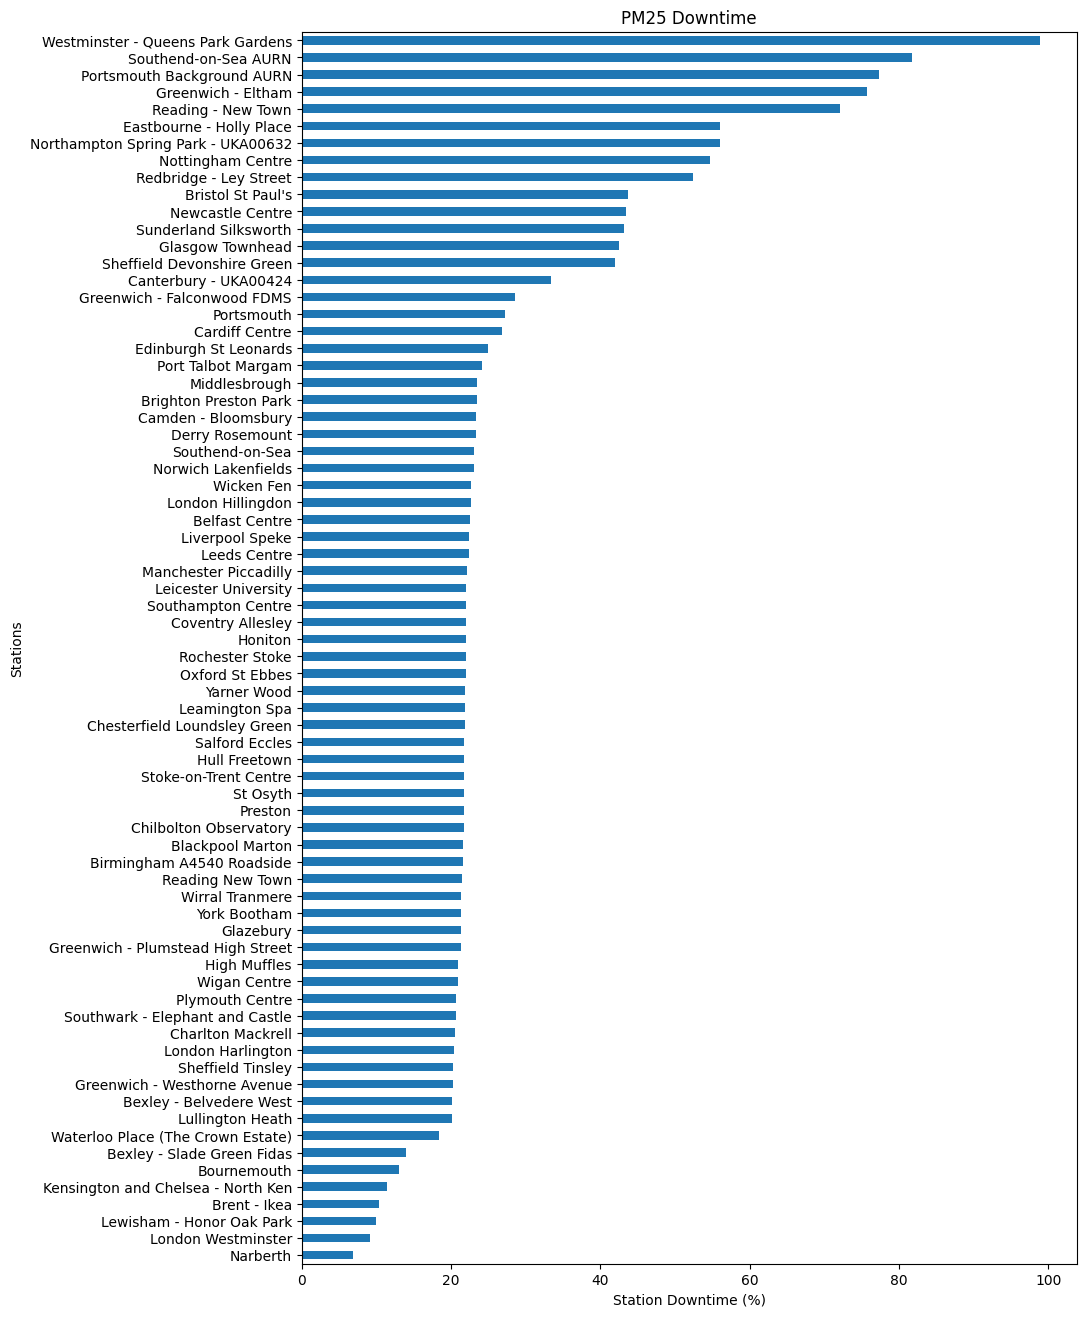

In [27]:
missing_stats = daily_pm25.apply(lambda x: x.isna().sum())
total_cell = len(daily_pm25)
plt.figure(figsize=(10, 16))
percent_miss = (missing_stats/total_cell)*100
percent_miss.sort_values().plot(kind='barh')
plt.xlabel('Station Downtime (%)')
plt.title('PM25 Downtime')
plt.ylabel('Stations')

In [28]:
a = percent_miss[percent_miss > 40].index.tolist()
weather = weather[~weather['station'].isin(a)]
for removed in a:
    print(f'Station: {removed} was removed')

Station: Bristol St Paul's was removed
Station: Eastbourne - Holly Place was removed
Station: Glasgow Townhead was removed
Station: Greenwich - Eltham was removed
Station: Newcastle Centre was removed
Station: Northampton Spring Park - UKA00632 was removed
Station: Nottingham Centre was removed
Station: Portsmouth Background AURN was removed
Station: Reading - New Town was removed
Station: Redbridge - Ley Street was removed
Station: Sheffield Devonshire Green was removed
Station: Southend-on-Sea AURN was removed
Station: Sunderland Silksworth was removed
Station: Westminster - Queens Park Gardens was removed


In [29]:
averaged_o3 = weather.groupby([weather['time'].dt.date, 'station'])['o3'].mean()
daily_o3 = averaged_o3.unstack(level='station')
daily_o3

station     Belfast Centre  Bexley - Belvedere West  \
time                                                  
2022-07-17       59.291667                78.621053   
2022-07-18       83.958333                80.790909   
2022-07-19       68.529412                99.125000   
2022-07-20       44.454545                80.104545   
2022-07-21       43.916667                50.027273   
...                    ...                      ...   
2025-07-11       33.371237                54.395652   
2025-07-12       44.820808                43.586957   
2025-07-13       36.833333                63.237500   
2025-07-14             NaN                66.670833   
2025-07-15             NaN                46.114286   

station     Bexley - Slade Green Fidas  Birmingham A4540 Roadside  \
time                                                                
2022-07-17                   70.590909                  61.083333   
2022-07-18                   91.336364                  67.041667   
2022-07-19                   93.313636                  78.666667   
2022-07-20                   88.086364                  65.777778   
2022-07-21                   55.063636                  32.041667   
...                                ...                        ...   
2025-07-11                   57.616667                  77.492475   
2025-07-12                   43.878261                  69.821166   
2025-07-13                   61.104762                  57.510539   
2025-07-14                   64.075000                  55.928818   
2025-07-15                         NaN                  36.869565   

station     Blackpool Marton  Bournemouth  Brent - Ikea  \
time                                                      
2022-07-17         67.583333    71.958333     55.909091   
2022-07-18         94.500000    95.750000     55.186364   
2022-07-19        114.583333   116.375000     61.490909   
2022-07-20         63.500000    68.111111     55.733333   
2022-07-21         50.833333    58.291667     30.490909   
...                      ...          ...           ...   
2025-07-11         44.288442    58.564284           NaN   
2025-07-12         73.796488    43.587170           NaN   
2025-07-13         37.400000    48.705882           NaN   
2025-07-14               NaN          NaN           NaN   
2025-07-15               NaN          NaN           NaN   

station     Brighton Preston Park  Camden - Bloomsbury  Canterbury - UKA00424  \
time                                                                            
2022-07-17              69.791667            74.704167              70.833333   
2022-07-18              98.166667            77.112500              88.000000   
2022-07-19             107.833333            72.945833             105.333333   
2022-07-20              63.833333            80.483333              89.833333   
2022-07-21              60.250000            42.745833              57.250000   
...                           ...                  ...                    ...   
2025-07-11              46.370252            77.234607                    NaN   
2025-07-12              47.923443            57.625000                    NaN   
2025-07-13              54.675941                  NaN                    NaN   
2025-07-14              61.711811                  NaN                    NaN   
2025-07-15              50.312500                  NaN                    NaN   

station     ...  Southend-on-Sea  Southwark - Elephant and Castle    St Osyth  \
time        ...                                                                 
2022-07-17  ...        69.541667                        75.493750   64.473684   
2022-07-18  ...        91.416667                        86.812500   53.600000   
2022-07-19  ...       105.083333                        59.300000  143.733333   
2022-07-20  ...        86.111111                        87.913333  101.777778   
2022-07-21  ...        53.625000                        48.700000   72.958333 

Text(0, 0.5, 'Stations')

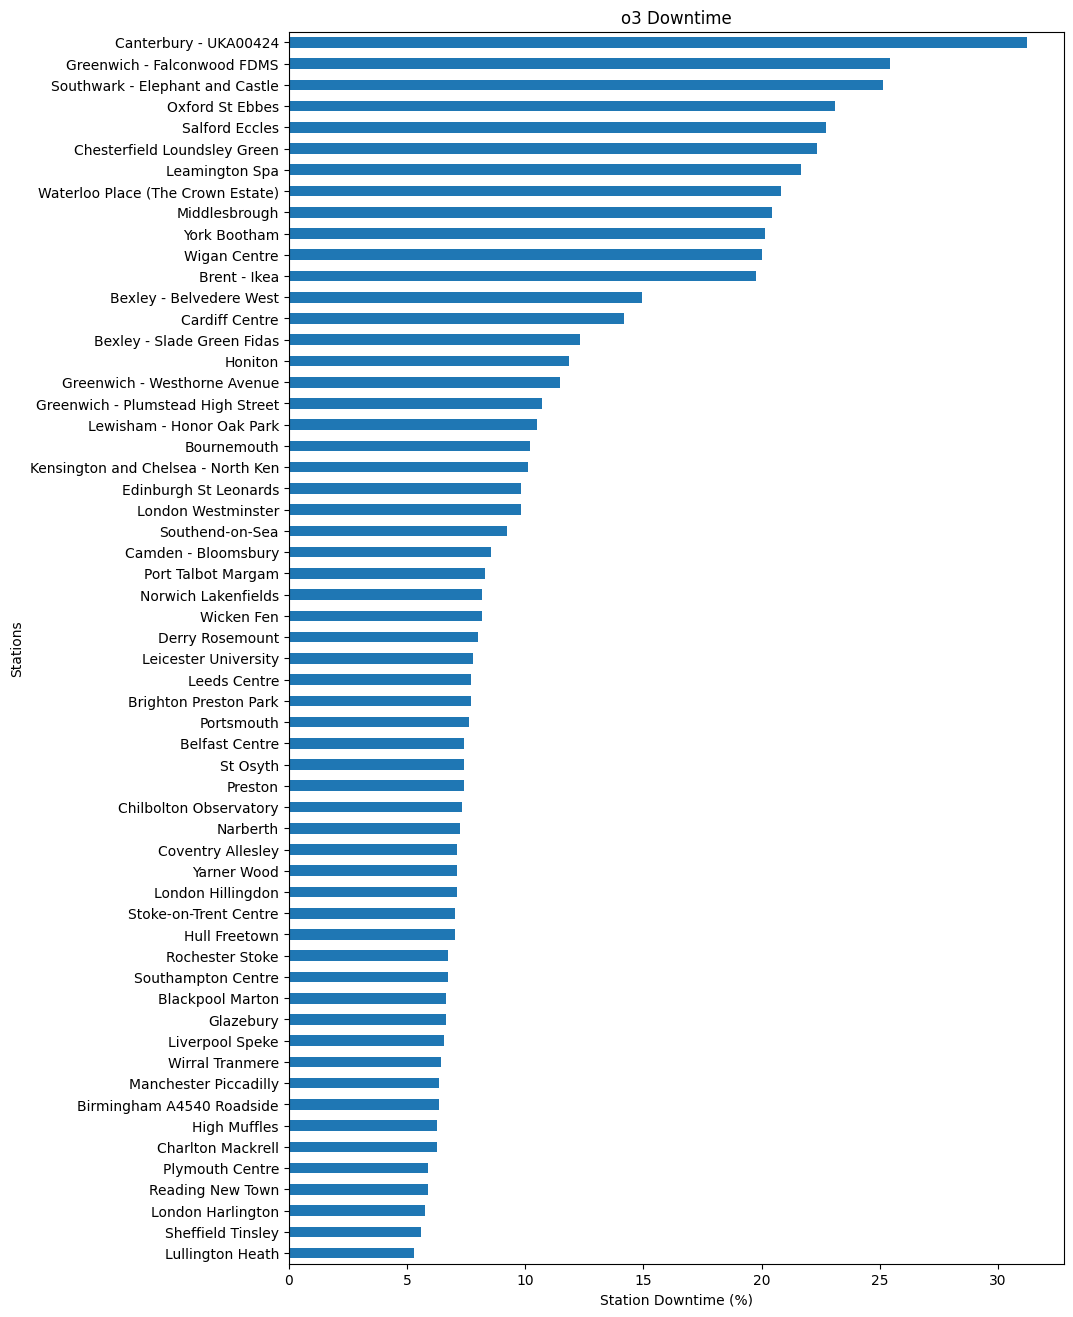

In [30]:
averaged_o3 = weather.groupby([weather['time'].dt.date, 'station'])['no2'].mean()
daily_o3 = averaged_o3.unstack(level='station')

missing_stats = daily_o3.apply(lambda x: x.isna().sum())
total_cell = len(daily_o3)
plt.figure(figsize=(10, 16))
percent_miss = (missing_stats/total_cell)*100
percent_miss.sort_values().plot(kind='barh')
plt.xlabel('Station Downtime (%)')
plt.title('o3 Downtime')
plt.ylabel('Stations')

In [31]:
a = percent_miss[percent_miss > 40].index.tolist()
weather_new = weather[~weather['station'].isin(a)]
for removed in a:
    print(f'Station: {removed} was removed')

Text(0, 0.5, 'Stations')

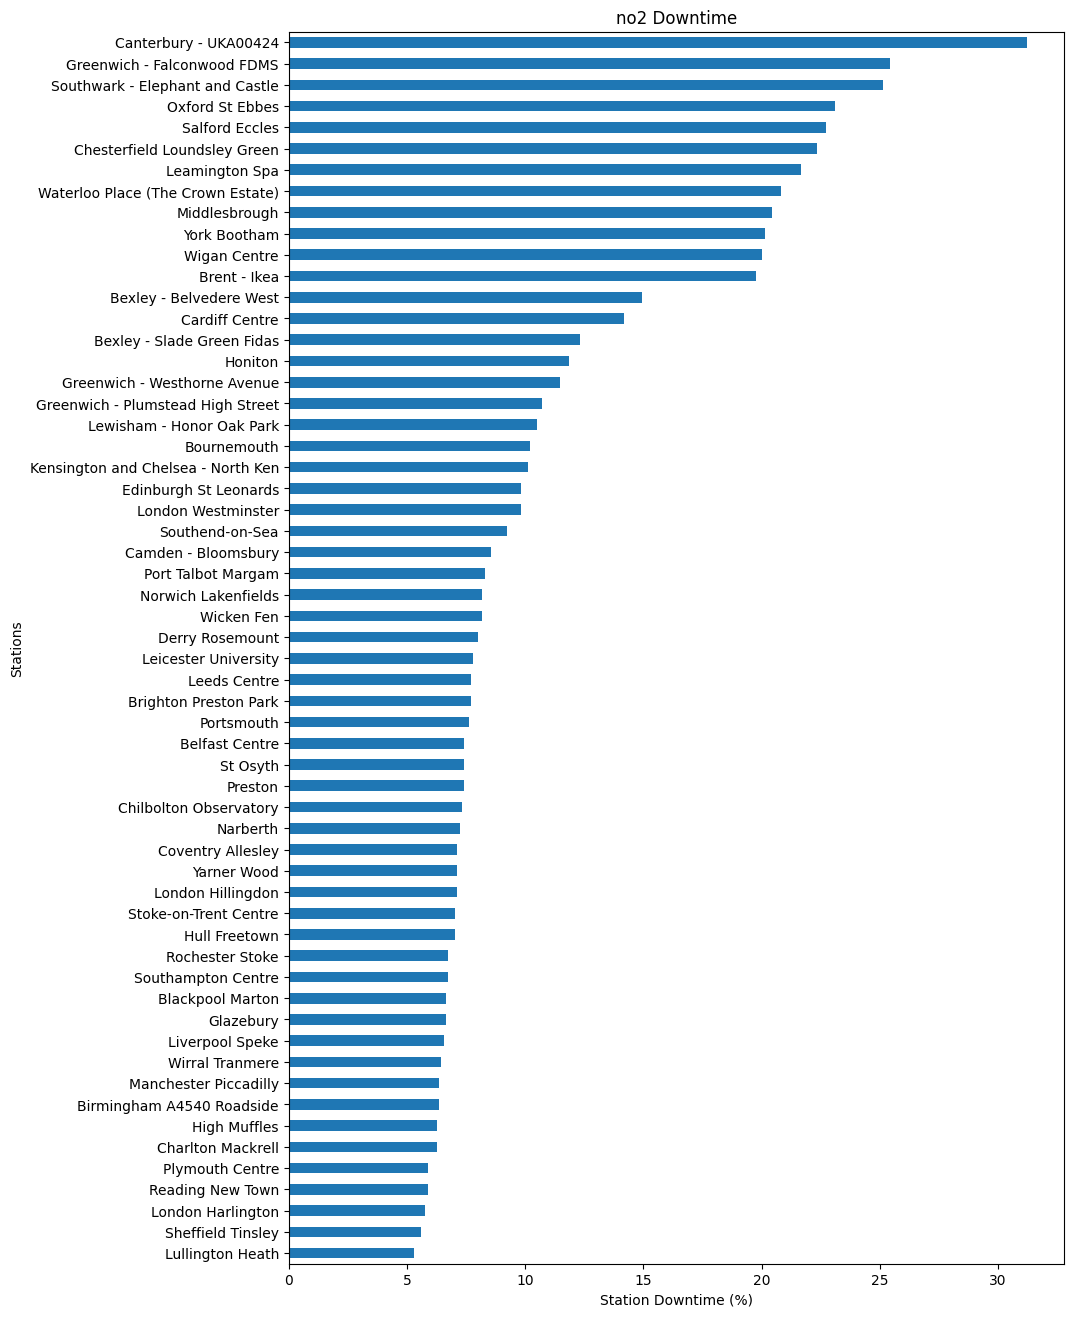

In [32]:
averaged_no2 = weather_new.groupby([weather_new['time'].dt.date, 'station'])['no2'].mean()
daily_no2 = averaged_no2.unstack(level='station')

missing_stats = daily_no2.apply(lambda x: x.isna().sum())
total_cell = len(daily_no2)
plt.figure(figsize=(10, 16))
percent_miss = (missing_stats/total_cell)*100
percent_miss.sort_values().plot(kind='barh')
plt.xlabel('Station Downtime (%)')
plt.title('no2 Downtime')
plt.ylabel('Stations')

It can be seen that when the station is down, all sensors are completely down, therefore no data is recorded. For other stations such as Westminister or Tower hamlets - They may have been newly built stations given their long downtime. 

Due to this project being a time series prediction project, we will have to remove the stations with the highest amount of downtime.

<Axes: >

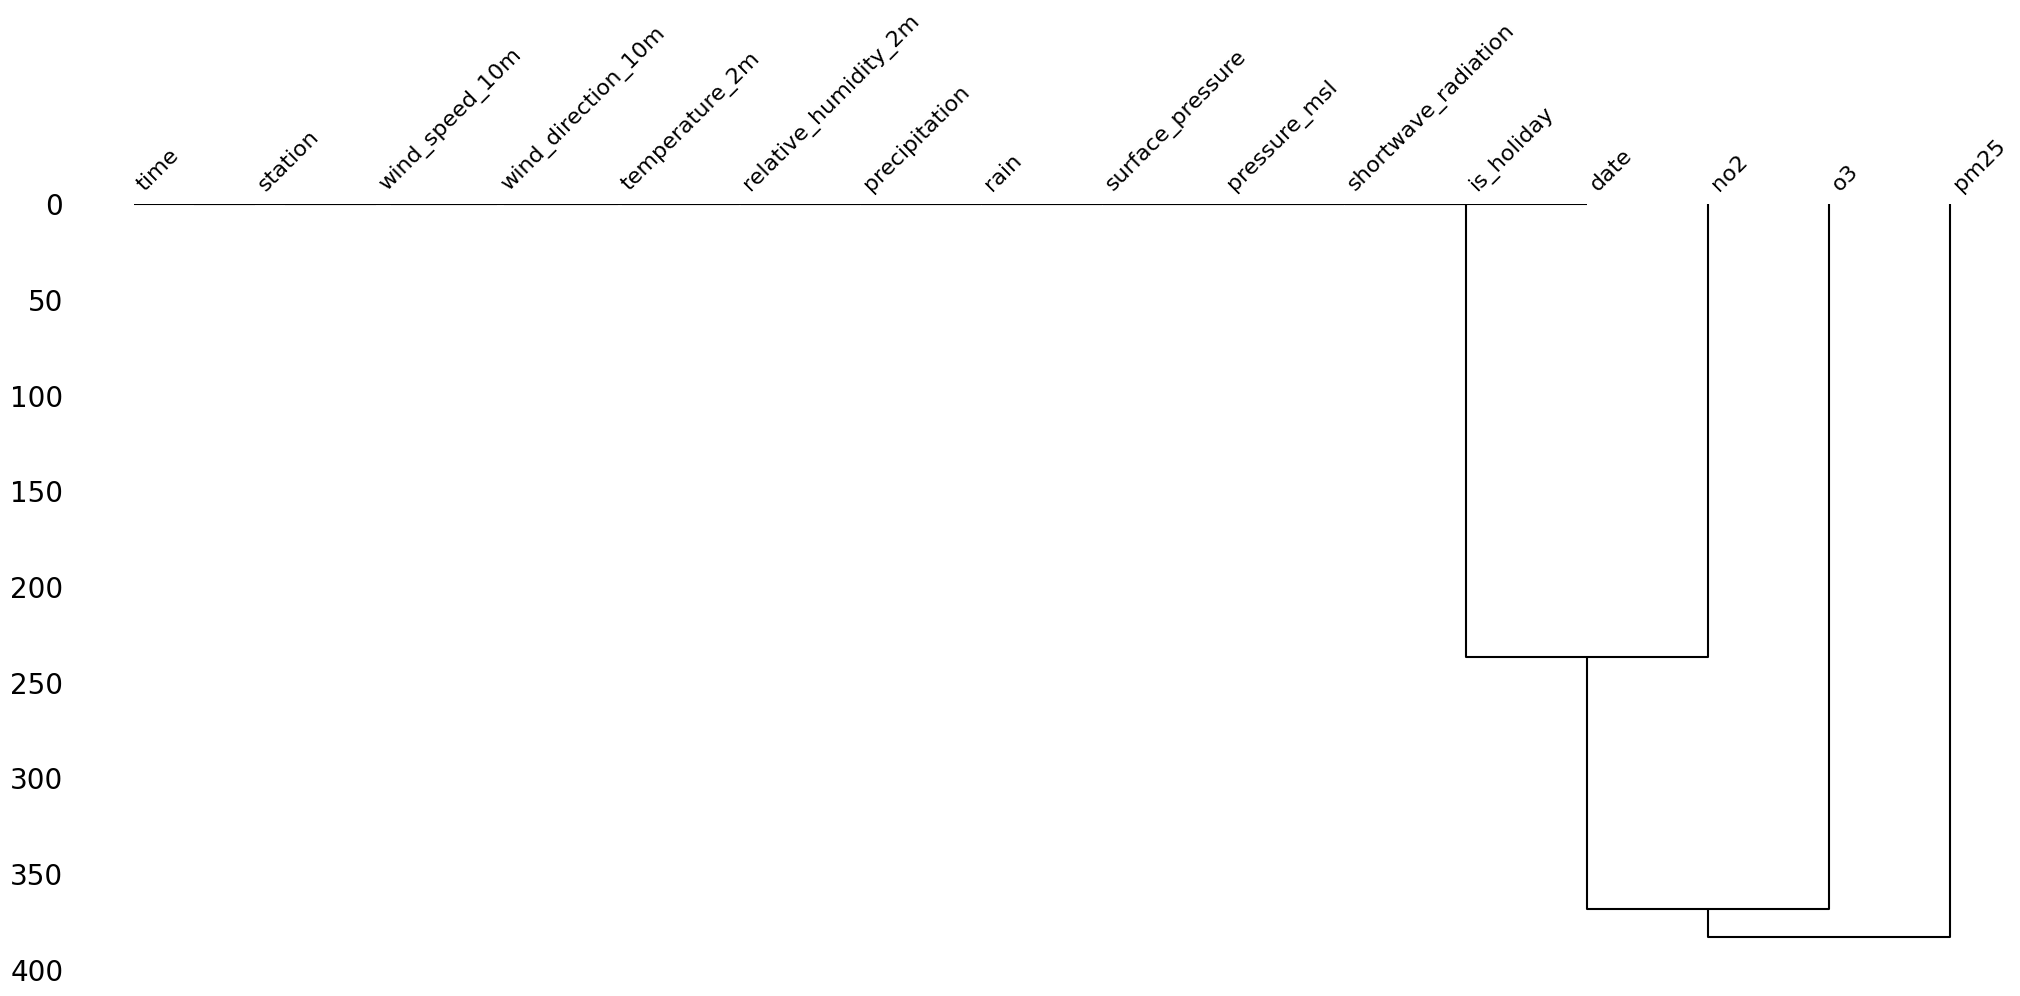

In [33]:
msno.dendrogram(weather)

In [34]:
averaged_o3 = weather.groupby([weather['time'].dt.date, 'station'])['o3'].mean()
daily_o3 = averaged_o3.unstack(level='station')
daily_o3

station     Belfast Centre  Bexley - Belvedere West  \
time                                                  
2022-07-17       59.291667                78.621053   
2022-07-18       83.958333                80.790909   
2022-07-19       68.529412                99.125000   
2022-07-20       44.454545                80.104545   
2022-07-21       43.916667                50.027273   
...                    ...                      ...   
2025-07-11       33.371237                54.395652   
2025-07-12       44.820808                43.586957   
2025-07-13       36.833333                63.237500   
2025-07-14             NaN                66.670833   
2025-07-15             NaN                46.114286   

station     Bexley - Slade Green Fidas  Birmingham A4540 Roadside  \
time                                                                
2022-07-17                   70.590909                  61.083333   
2022-07-18                   91.336364                  67.041667   
2022-07-19                   93.313636                  78.666667   
2022-07-20                   88.086364                  65.777778   
2022-07-21                   55.063636                  32.041667   
...                                ...                        ...   
2025-07-11                   57.616667                  77.492475   
2025-07-12                   43.878261                  69.821166   
2025-07-13                   61.104762                  57.510539   
2025-07-14                   64.075000                  55.928818   
2025-07-15                         NaN                  36.869565   

station     Blackpool Marton  Bournemouth  Brent - Ikea  \
time                                                      
2022-07-17         67.583333    71.958333     55.909091   
2022-07-18         94.500000    95.750000     55.186364   
2022-07-19        114.583333   116.375000     61.490909   
2022-07-20         63.500000    68.111111     55.733333   
2022-07-21         50.833333    58.291667     30.490909   
...                      ...          ...           ...   
2025-07-11         44.288442    58.564284           NaN   
2025-07-12         73.796488    43.587170           NaN   
2025-07-13         37.400000    48.705882           NaN   
2025-07-14               NaN          NaN           NaN   
2025-07-15               NaN          NaN           NaN   

station     Brighton Preston Park  Camden - Bloomsbury  Canterbury - UKA00424  \
time                                                                            
2022-07-17              69.791667            74.704167              70.833333   
2022-07-18              98.166667            77.112500              88.000000   
2022-07-19             107.833333            72.945833             105.333333   
2022-07-20              63.833333            80.483333              89.833333   
2022-07-21              60.250000            42.745833              57.250000   
...                           ...                  ...                    ...   
2025-07-11              46.370252            77.234607                    NaN   
2025-07-12              47.923443            57.625000                    NaN   
2025-07-13              54.675941                  NaN                    NaN   
2025-07-14              61.711811                  NaN                    NaN   
2025-07-15              50.312500                  NaN                    NaN   

station     ...  Southend-on-Sea  Southwark - Elephant and Castle    St Osyth  \
time        ...                                                                 
2022-07-17  ...        69.541667                        75.493750   64.473684   
2022-07-18  ...        91.416667                        86.812500   53.600000   
2022-07-19  ...       105.083333                        59.300000  143.733333   
2022-07-20  ...        86.111111                        87.913333  101.777778   
2022-07-21  ...        53.625000                        48.700000   72.958333 

I decided to set the threshold at 40% because I want to ensure the data is high quality.

We still have 1.2m rows, which is still a lot of data. We haven't lost that much data which is good for us.

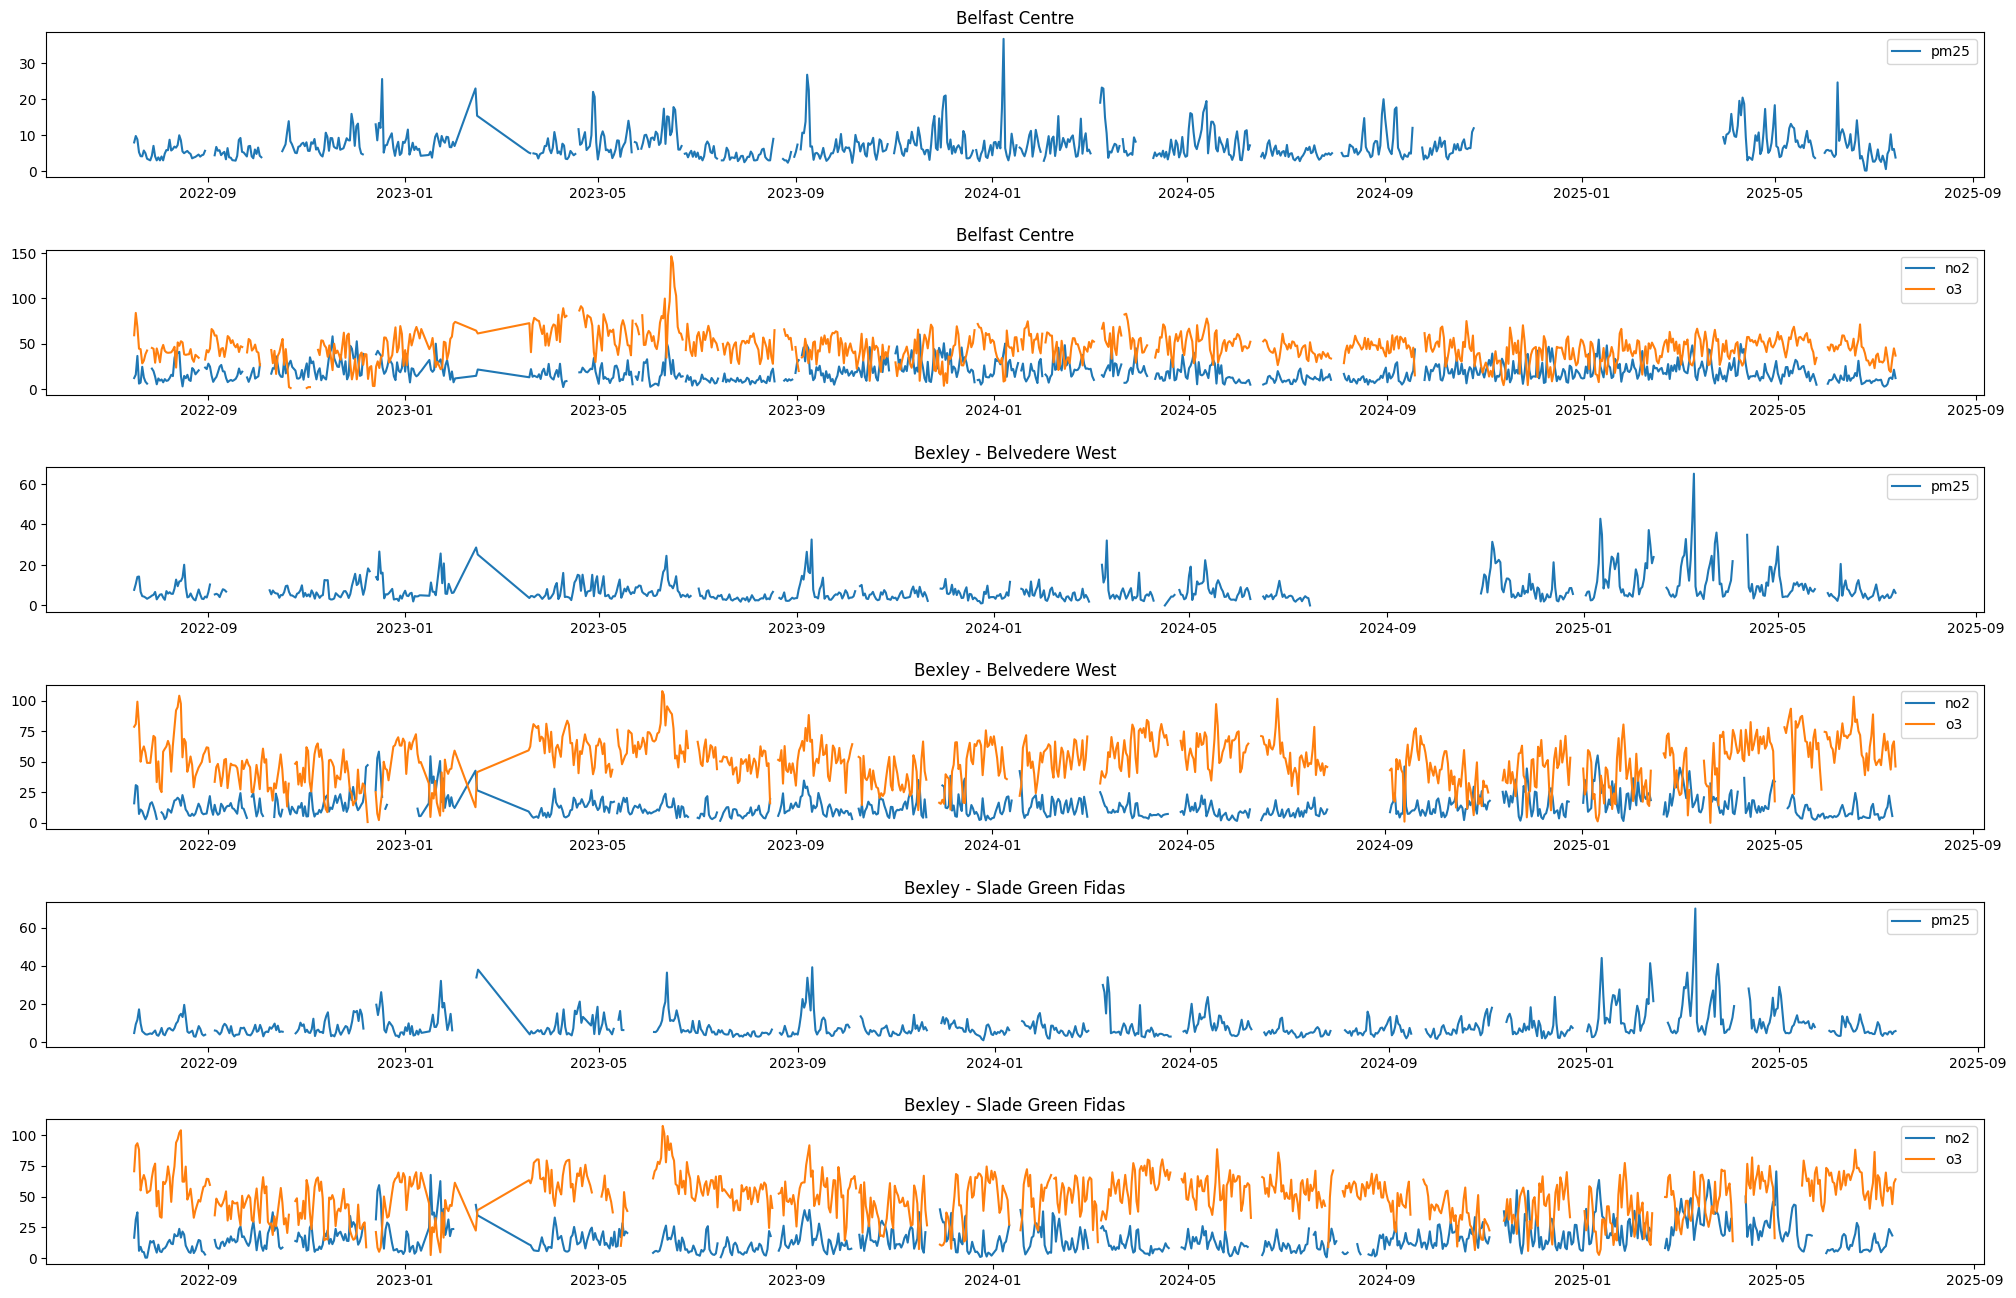

In [35]:
stations = weather_new['station'].unique()[:3]


fig, axs = plt.subplots(len(stations)*2, 1, figsize=(25, 16))
plt.subplots_adjust(hspace=0.5)
for i, station in enumerate(stations):

    averaged_no2 = weather_new.groupby([weather_new['time'].dt.date, 'station'])['no2'].mean()
    daily_no2 = averaged_no2.unstack(level='station')
    destination_data = daily_no2[stations[i]]
    axs[i*2 + 1].plot(destination_data.index, destination_data)
    axs[i*2 + 1].set_title(f'{station}')
    averaged_o3 = weather_new.groupby([weather_new['time'].dt.date, 'station'])['o3'].mean()
    daily_o3 = averaged_o3.unstack(level='station')
    
    
    destination_data = daily_o3[stations[i]]
    axs[i*2 + 1].plot(destination_data.index, destination_data)
    axs[i*2 + 1].legend(['no2', 'o3'])
    
    averaged_pm25 = weather_new.groupby([weather_new['time'].dt.date, 'station'])['pm25'].mean()
    daily_pm25 = averaged_pm25.unstack(level='station')
    
    destination_data = daily_pm25[stations[i]]
    axs[i*2].plot(destination_data.index, destination_data)
    axs[i*2].set_title(f'{station}')
    axs[i*2].legend(['pm25'])


Talk about the graph above.

In [36]:
# lags = [1, 2, 3, 6, 12, 24]
# features_add = []
# removal = []
# polutant = ['o3', 'pm25']
# for pol in polutant:
#     for lag in lags:
#         weather_new[f'{pol}_lag_{lag}'] = weather_new.groupby(['station'])[f'{pol}'].shift(lag)
#         weather_new[f'time_shift_{lag}'] = weather_new.groupby('station')['time'].shift(lag)
#         time_diff = weather_new['time'] - weather_new[f'time_shift_{lag}']
#         weather_new.loc[time_diff > pd.Timedelta(hours=lag), f'{pol}_lag_{lag}'] = np.nan
#         removal.append(f'time_shift_{lag}')
#         features_add.append(f'{pol}_lag_{lag}')


In [37]:

# lags = [1, 2, 3, 6, 12, 24]
# features_add = []
# removal = []
# polutant = ['o3', 'pm25']
# for pol in polutant:
#     for lag in lags:
#         weather_new[f'{pol}_lag_{lag}'] = weather_new.groupby(['station'])[f'{pol}'].shift(lag)
#         weather_new[f'time_shift_{lag}'] = weather_new.groupby('station')['time'].shift(lag)
#         time_diff = weather_new['time'] - weather_new[f'time_shift_{lag}']
#         weather_new.loc[time_diff > pd.Timedelta(hours=lag), f'{pol}_lag_{lag}'] = np.nan
#         removal.append(f'time_shift_{lag}')
#         features_add.append(f'{pol}_lag_{lag}')
        
# rollings = [1, 2, 3, 6, 12, 24]
# polutant = ['pm25', 'o3']
# weather_new = weather_new.sort_values(['station', 'time']).set_index('time')
# for pol in polutant:
#     for roll in rollings:
#         weather_new[f'{pol}_rolling_{roll}'] = weather_new.groupby('station')[f'{pol}'].rolling(f'{roll}h', min_periods=1).mean().reset_index(level=0, drop=True).shift(1)
#         features_add.append(f'{pol}_rolling_{roll}')
        

# for pol in polutant:
#     for roll in rollings:
#         weather_new[f'{pol}_rolling_std_{roll}'] = weather_new.groupby('station')[f'{pol}'].rolling(f'{roll}h', min_periods=1).std().reset_index(level=0, drop=True).shift(1)
#         features_add.append(f'{pol}_rolling_std_{roll}')


# for pol in polutant:
#     for roll in rollings:
#         weather_new[f'{pol}_rolling_min_{roll}'] = weather_new.groupby('station')[f'{pol}'].rolling(f'{roll}h', min_periods=1).min().reset_index(level=0, drop=True).shift(1)
#         features_add.append(f'{pol}_rolling_min_{roll}')


# for pol in polutant:
#     for roll in rollings:
#         weather_new[f'{pol}_rolling_max_{roll}'] = weather_new.groupby('station')[f'{pol}'].rolling(f'{roll}h', min_periods=1).max().reset_index(level=0, drop=True).shift(1)
#         features_add.append(f'{pol}_rolling_max_{roll}')



In [38]:
weather_new = weather_new.sort_values(['station', 'time']).set_index('time')
weather_new['day_of_week'] = weather_new.index.day_name()
weather_new['date'] = weather_new.index.date
weather_new['hour'] = weather_new.index.hour

weather_new['hour_sin'] = np.sin(2 * np.pi * weather_new['hour']/24)
weather_new['hour_cos'] = np.cos(2 * np.pi * weather_new['hour']/24)



In [39]:
weather_new.isna().sum()

station                      0
no2                      56180
o3                      135256
pm25                    139417
wind_speed_10m               0
wind_direction_10m           0
temperature_2m               0
relative_humidity_2m         0
precipitation                0
rain                         0
surface_pressure             0
pressure_msl                 0
shortwave_radiation          0
is_holiday                   0
date                         0
day_of_week                  0
hour                         0
hour_sin                     0
hour_cos                     0
dtype: int64

In [40]:
weather_new.isna().sum()

station                      0
no2                      56180
o3                      135256
pm25                    139417
wind_speed_10m               0
wind_direction_10m           0
temperature_2m               0
relative_humidity_2m         0
precipitation                0
rain                         0
surface_pressure             0
pressure_msl                 0
shortwave_radiation          0
is_holiday                   0
date                         0
day_of_week                  0
hour                         0
hour_sin                     0
hour_cos                     0
dtype: int64

There is clearly too many missing gaps in lag 12 & 14. This sparsity can create noise within our model, even though the model we will be using can handle NaN entries, it's wise to remove them, however we can at least try to impute lag 1-6 for both o3 and pm25

In [41]:
weather_new['no2'] = weather_new['no2'].ffill(limit=24).bfill(limit=24)

<div style="background-image: url('https://images.unsplash.com/photo-1506905925346-21bda4d32df4?w=1200');
            background-size: cover;
            background-position: center;
            height: 200px;
            border-radius: 15px;
            display: flex;
            align-items: center;
            justify-content: center;
            position: relative;">
    <div style="background: rgba(0,0,0,0.3); 
                padding: 20px; 
                border-radius: 10px; 
                color: white;
                text-align: center;">
        <h1 style="margin: 0;">1. Feature Engineering</h1>
    </div>
</div>


In [42]:
weather_new['wind_humidity_interaction'] = weather_new['wind_speed_10m'] * weather_new['relative_humidity_2m']

In [43]:
weather_new.columns

Index(['station', 'no2', 'o3', 'pm25', 'wind_speed_10m', 'wind_direction_10m',
       'temperature_2m', 'relative_humidity_2m', 'precipitation', 'rain',
       'surface_pressure', 'pressure_msl', 'shortwave_radiation', 'is_holiday',
       'date', 'day_of_week', 'hour', 'hour_sin', 'hour_cos',
       'wind_humidity_interaction'],
      dtype='object')

In [44]:
weather_new['wind_dir_sin'] = np.sin(np.radians(weather_new['wind_direction_10m']))
weather_new['wind_dir_cos'] = np.cos(np.radians(weather_new['wind_direction_10m']))
weather_new

station   no2    o3  pm25  wind_speed_10m  \
time                                                                          
2022-07-17 00:00:00+00:00  Belfast Centre  14.0  43.0   7.0        5.154415   
2022-07-17 01:00:00+00:00  Belfast Centre  16.0  40.0   7.0        4.680000   
2022-07-17 02:00:00+00:00  Belfast Centre  17.0  39.0   7.0        6.439876   
2022-07-17 03:00:00+00:00  Belfast Centre  17.0  39.0   7.0        7.172949   
2022-07-17 04:00:00+00:00  Belfast Centre   9.0  40.0   7.0        5.623380   
...                                   ...   ...   ...   ...             ...   
2025-07-15 11:00:00+00:00    York Bootham   7.0  38.0   NaN       15.137133   
2025-07-15 12:00:00+00:00    York Bootham   7.0  38.0   NaN       18.643690   
2025-07-15 13:00:00+00:00    York Bootham   7.0  35.0   NaN       22.528780   
2025-07-15 14:00:00+00:00    York Bootham   7.0  35.0   NaN       24.332644   
2025-07-15 16:00:00+00:00    York Bootham   7.0  32.0   NaN       21.869816   

                           wind_direction_10m  temperature_2m  \
time                                                            
2022-07-17 00:00:00+00:00          114.775116       14.488000   
2022-07-17 01:00:00+00:00          112.619910       13.938001   
2022-07-17 02:00:00+00:00          153.435010       14.438001   
2022-07-17 03:00:00+00:00          197.525670       14.888001   
2022-07-17 04:00:00+00:00          140.194470       14.888001   
...                                       ...             ...   
2025-07-15 11:00:00+00:00          177.273740       16.161001   
2025-07-15 12:00:00+00:00          169.992080       16.811000   
2025-07-15 13:00:00+00:00          172.193700       15.361000   
2025-07-15 14:00:00+00:00          177.031830       15.111000   
2025-07-15 16:00:00+00:00          185.194340       17.261000   

                           relative_humidity_2m  precipitation  rain  ...  \
time                                                                  ...   
2022-07-17 00:00:00+00:00             86.647680            0.0   0.0  ...   
2022-07-17 01:00:00+00:00             84.056150            0.0   0.0  ...   
2022-07-17 02:00:00+00:00             78.723180            0.0   0.0  ...   
2022-07-17 03:00:00+00:00             77.751450            1.1   1.1  ...   
2022-07-17 04:00:00+00:00             81.976660            1.3   1.3  ...   
...                                         ...            ...   ...  ...   
2025-07-15 11:00:00+00:00             80.542470            1.1   1.1  ...   
2025-07-15 12:00:00+00:00             76.275190            0.3   0.3  ...   
2025-07-15 13:00:00+00:00             92.257970            1.6   1.6  ...   
2025-07-15 14:00:00+00:00             91.052956            1.0   1.0  ...   
2025-07-15 16:00:00+00:00             78.876480            0.1   0.1  ...   

                           shortwave_radiation  is_holiday        date  \
time                                                                     
2022-07-17 00:00:00+00:00                  0.0           0  2022-07-17   
2022-07-17 01:00:00+00:00                  0.0           0  2022-07-17   
2022-07-17 02:00:00+00:00                  0.0           0  2022-07-17   
2022-07-17 03:00:00+00:00                  0.0           0  2022-07-17   
2022-07-17 04:00:00+00:00                  0.0           0  2022-07-17   
...                                        ...         ...         ...   
2025-07-15 11:00:00+00:00                188.0           0  2025-07-15   
2025-07-15 12:00:00+00:00                137.0           0  2025-07-15   
2025-07-15 13:00:00+00:00                164.0           0  2025-07-15   
2025-07-15 14:00:00+00:00                 98.0           0  2025-07-15   
2025-07-15 16:00:00+00:00                414.0           0  2025-07-15   

                           day_of_week hour      hour_sin  hour_cos  \
time                                                                  
2022-07-17 00:00:00+00:00       Sunday    0  0.000000

<Axes: >

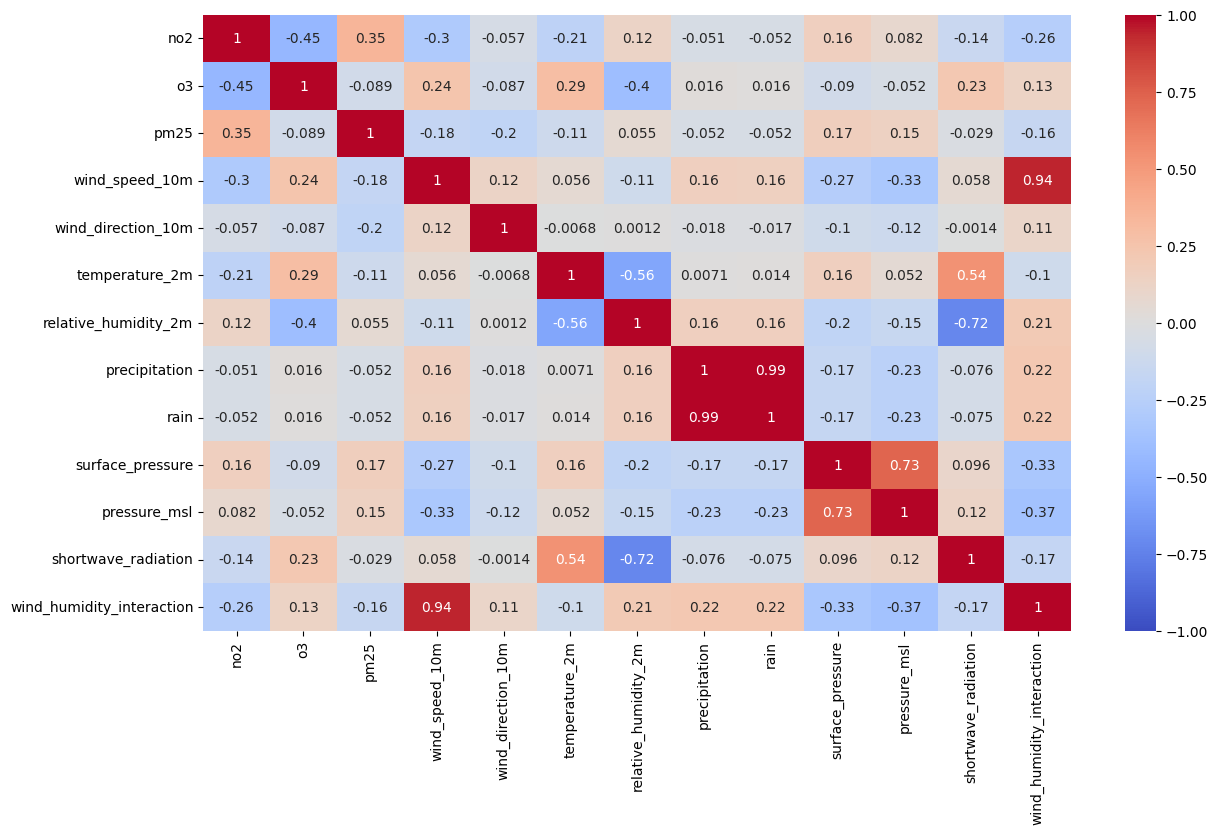

In [45]:
stuff = ['no2',
 'o3',
 'pm25',
 'wind_speed_10m',
 'wind_direction_10m',
 'temperature_2m',
 'relative_humidity_2m',
 'precipitation',
 'rain',
 'surface_pressure',
 'pressure_msl',
 'shortwave_radiation',
 'wind_humidity_interaction']
plt.figure(figsize=(14,8))
corr = weather_new[stuff].corr() 
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)

In [46]:
# features_add.extend(['no2', 'pm25', 'o3'])
# plt.figure(figsize=(14,8))
# corr = weather_new[features_add].corr() 
# sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)



<div style="background-image: url('https://external-preview.redd.it/4DD9toe34_3xPVCyEQVTcFuZKCnp5mNEfNeW98kWuG4.jpg?auto=webp&s=f27432834afe60efc99b28ed8f9dccecd2efecef');
            background-size: cover;
            background-position: center;
            height: 200px;
            border-radius: 15px;
            display: flex;
            align-items: center;
            justify-content: center;
            position: relative;">
    <div style="background: rgba(0,0,0,0.3); 
                padding: 20px; 
                border-radius: 10px; 
                color: white;
                text-align: center;">
        <h1 style="margin: 0;">1. Observing temporal data by Day of Week </h1>
    </div>
</div>


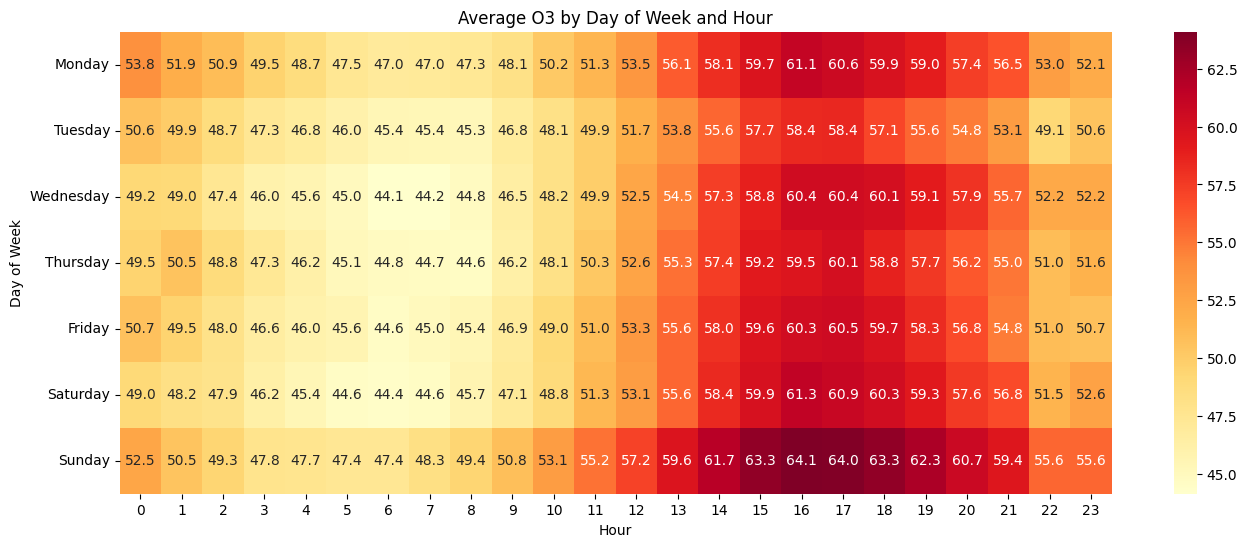

In [47]:
heat = weather_new.pivot_table(
    index='day_of_week',
    columns='hour',
    values='o3',
    aggfunc='mean'
)
heat = heat.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

plt.figure(figsize=(16,6))
sns.heatmap(heat, cmap='YlOrRd', annot=True, fmt=".1f")
plt.xlabel('Hour')
plt.ylabel('Day of Week')
plt.title('Average O3 by Day of Week and Hour')
plt.show()

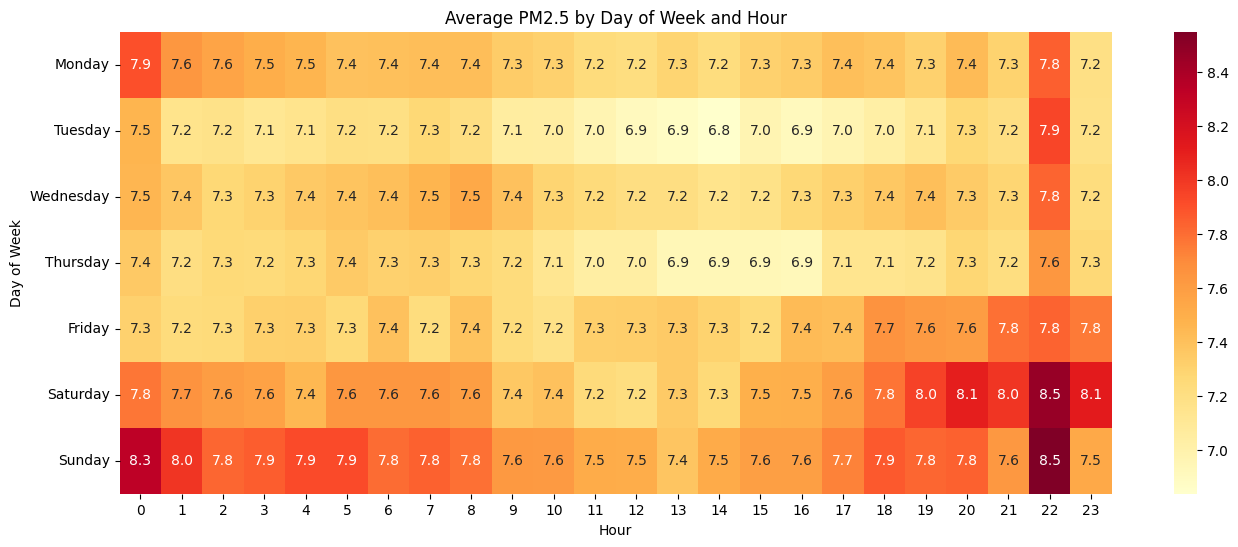

In [48]:
heat = weather_new.pivot_table(
    index='day_of_week',
    columns='hour',
    values='pm25',
    aggfunc='mean'
)
heat = heat.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

plt.figure(figsize=(16,6))
sns.heatmap(heat, cmap='YlOrRd', annot=True, fmt=".1f")
plt.xlabel('Hour')
plt.ylabel('Day of Week')
plt.title('Average PM2.5 by Day of Week and Hour')
plt.show()

The o3 clearly rises late in the evening, which makes sense as the o3 i

# Do features affect polutants?

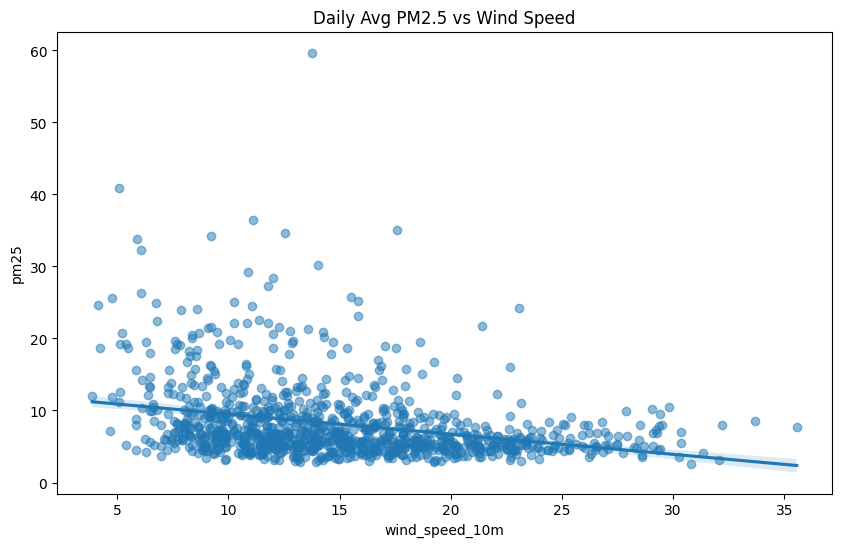

In [49]:
wind = weather_new.groupby(weather_new.index.date).agg(
    {
        'pm25': 'mean',
        'wind_speed_10m': 'mean'
    }
).reset_index()
plt.figure(figsize=(10,6))
sns.regplot(wind, y = 'pm25', x = 'wind_speed_10m', scatter_kws={"alpha":0.5})
plt.title("Daily Avg PM2.5 vs Wind Speed")
plt.show()

We can see that there is a downward trend, as the wind speed increases, the pm25 becomes scattered therefore making the station recordings lower.

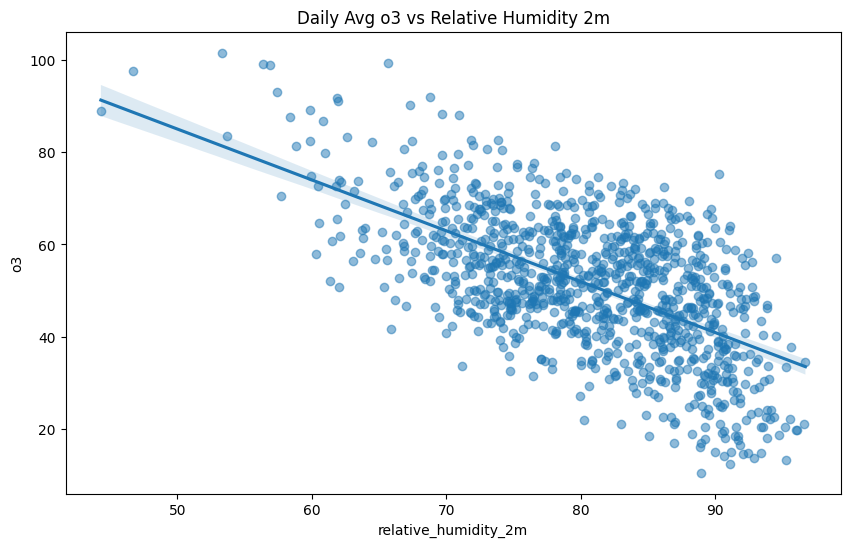

In [50]:
wind = weather_new.groupby(weather_new.index.date).agg(
    {
        'o3': 'mean',
        'relative_humidity_2m': 'mean'
    }
).reset_index()
plt.figure(figsize=(10,6))
sns.regplot(wind, y = 'o3', x = 'relative_humidity_2m', scatter_kws={"alpha":0.5})
plt.title("Daily Avg o3 vs Relative Humidity 2m")
plt.show()

## Does particulate matte 2.5 spike during holidays?

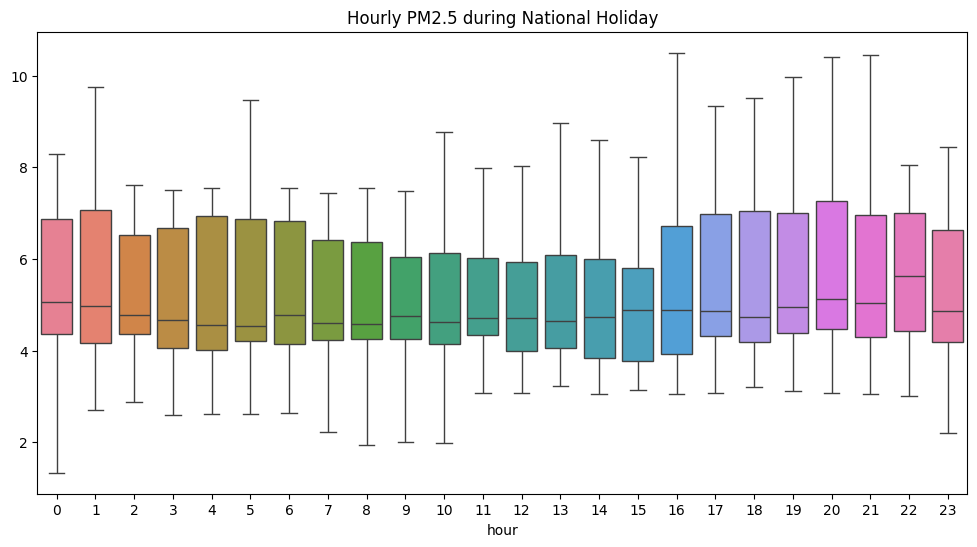

In [51]:
heat = weather_new[weather_new['is_holiday'] == 1].pivot_table(
    index='date',
    columns='hour',
    values='pm25'
)
plt.figure(figsize=(12,6))
sns.boxplot(data=heat, showfliers=False)
plt.title('Hourly PM2.5 during National Holiday')
plt.show()


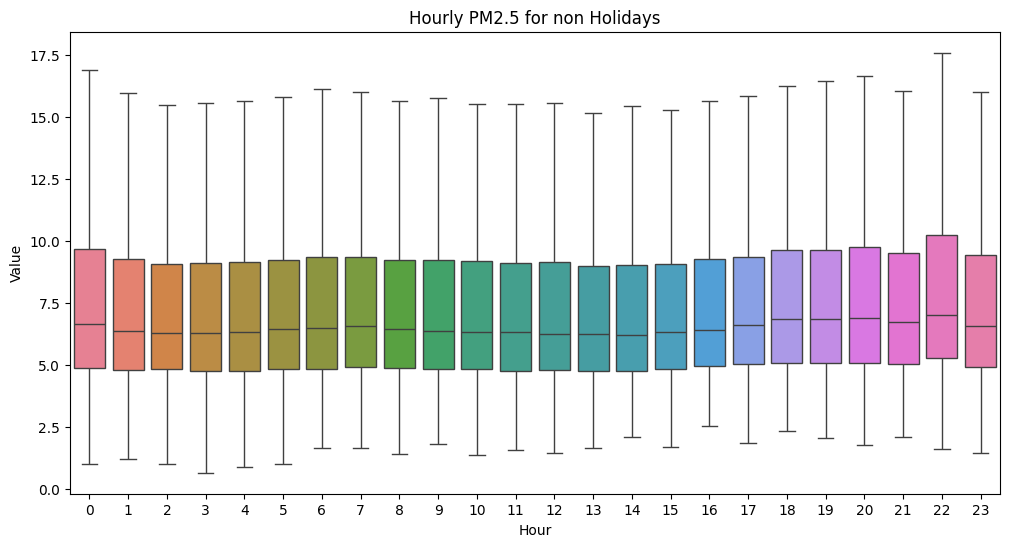

In [52]:
heat = weather_new[weather_new['is_holiday'] != 1].pivot_table(
    index='date',
    columns='hour',
    values='pm25'
)
plt.figure(figsize=(12,6))
sns.boxplot(data=heat, showfliers=False)
plt.title('Hourly PM2.5 for non Holidays')
plt.xlabel('Hour')
plt.ylabel('Value')
plt.show()

Yes, it can be seen that there is a clear spike shown in the boxplots, the medians are above 6 in contrast to holiday seaons. The 3rd pentile ranges are also higher. When we're talking about holidays, this means national holidays i.e Christmas. However it may be a bit skewed because majority of the holidays are bank holidays however there will be a drop in the usage of cars.

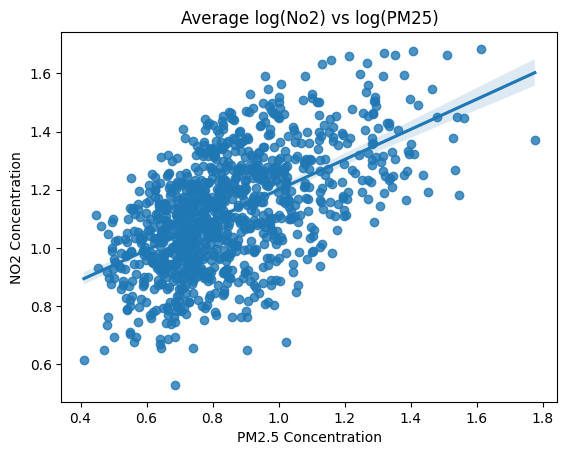

In [53]:
wind = weather_new.groupby(weather_new.index.date).agg(
    {
        'no2': 'mean',
        'pm25': 'mean'
    }
).reset_index()

wind['log_pm25'] = np.log10(wind['pm25'])
wind['log_no2'] = np.log10(wind['no2'])
ax = sns.regplot(wind, x='log_pm25', y='log_no2')
plt.title('Average log(No2) vs log(PM25)')
ax.set_xlabel('PM2.5 Concentration')
ax.set_ylabel('NO2 Concentration')
plt.show()

## Weekend vs Weekday - Is there a difference?

In [54]:
weather_new['is_weekend'] = weather_new.index.day_of_week > 4

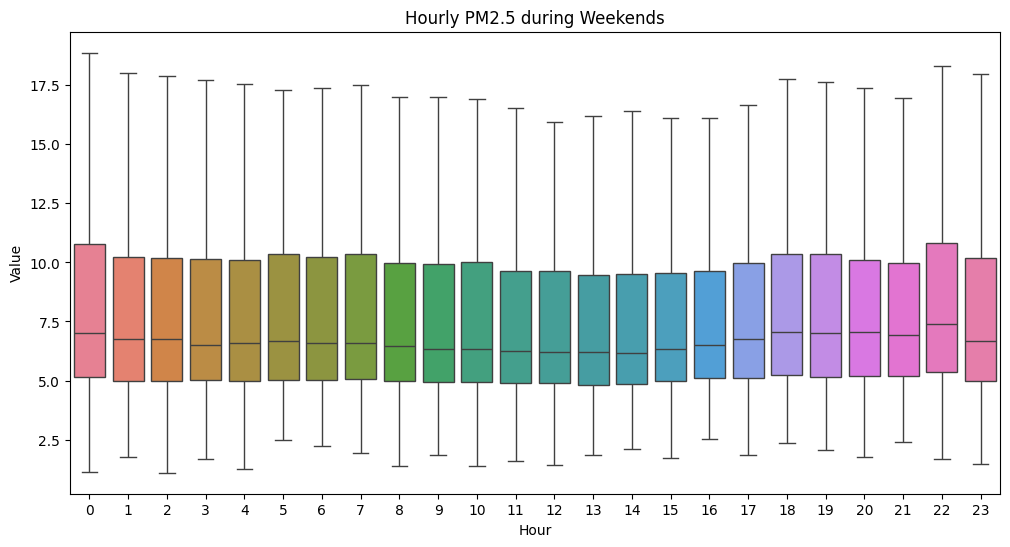

In [55]:
weekends = weather_new[weather_new['is_weekend'] == 1].pivot_table(
    index='date',
    columns='hour',
    values='pm25'
)
plt.figure(figsize=(12,6))
sns.boxplot(data=weekends, showfliers=False)
plt.title('Hourly PM2.5 during Weekends')
plt.xlabel('Hour')
plt.ylabel('Value')
plt.show()

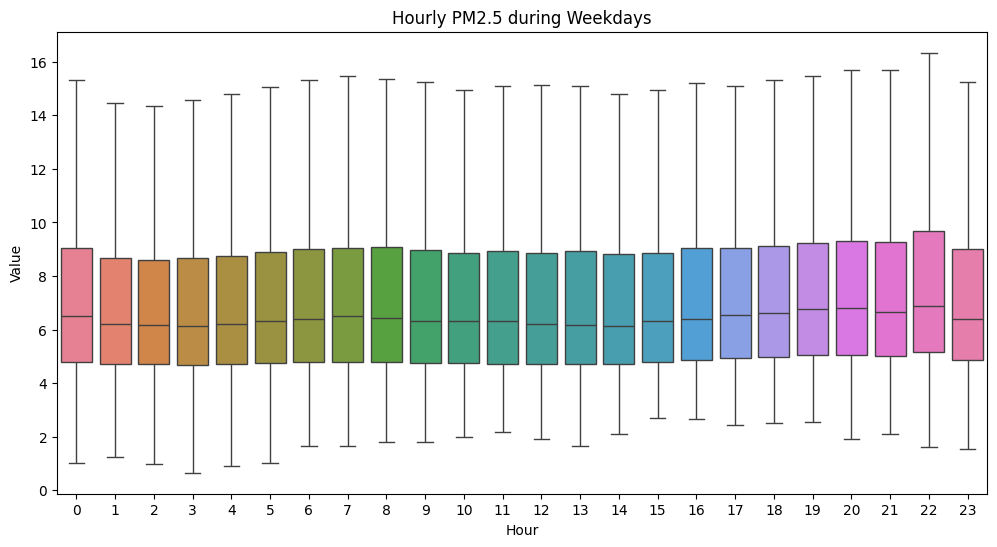

In [56]:
weekends = weather_new[weather_new['is_weekend'] !=1].pivot_table(
    index='date',
    columns='hour',
    values='pm25'
)
plt.figure(figsize=(12,6))
sns.boxplot(data=weekends, showfliers=False)
plt.title('Hourly PM2.5 during Weekdays')
plt.xlabel('Hour')
plt.ylabel('Value')
plt.show()

From observing both boxplots, it's clear that there is a rise during the weekends, the median, IQR are all much higher. So it's clear that people are travelling by car or other transportation a lot more during the weekends in comparison to weekdays.

# Observing patterns in polution

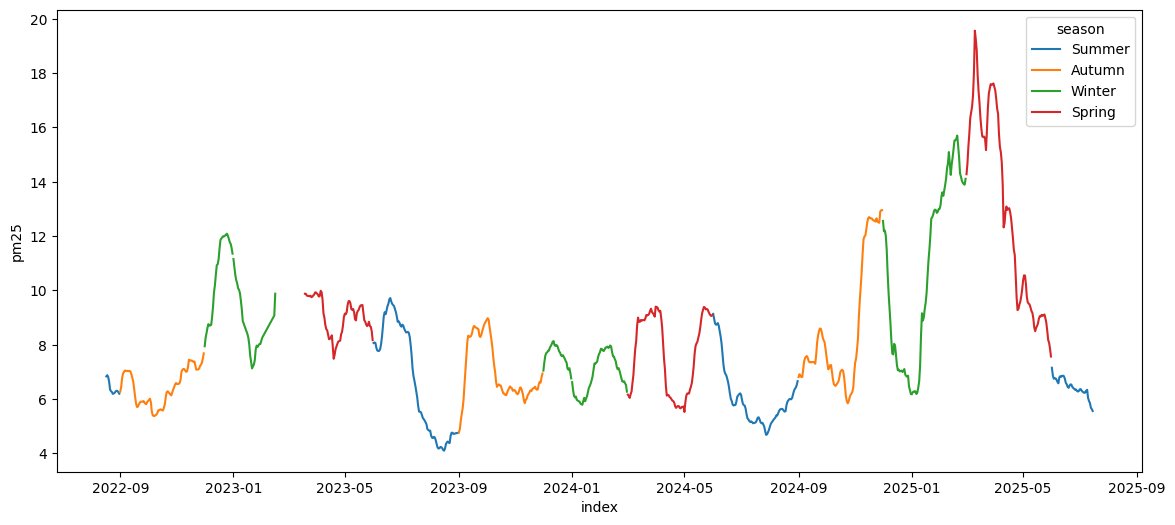

In [57]:
wind = weather_new.groupby(weather_new.index.date)['pm25'].mean().rolling(window=31).mean().reset_index()
month_to_season = {
    12: 'Winter', 1: 'Winter', 2: 'Winter',
    3: 'Spring', 4: 'Spring', 5: 'Spring',
    6: 'Summer', 7: 'Summer', 8: 'Summer',
    9: 'Autumn', 10: 'Autumn', 11: 'Autumn'
}

wind['index'] = pd.to_datetime(wind['index'])
wind['month'] = wind['index'].dt.month
wind['year'] = wind['index'].dt.year
wind['season'] = wind['month'].map(month_to_season)

wind['season_block'] = (wind['season'].ne(wind['season'].shift()) | wind['year'].ne(wind['year'].shift())).cumsum()
plt.figure(figsize=(14,6))
sns.lineplot(wind, x='index', y='pm25', hue='season', units='season_block')
plt.show()



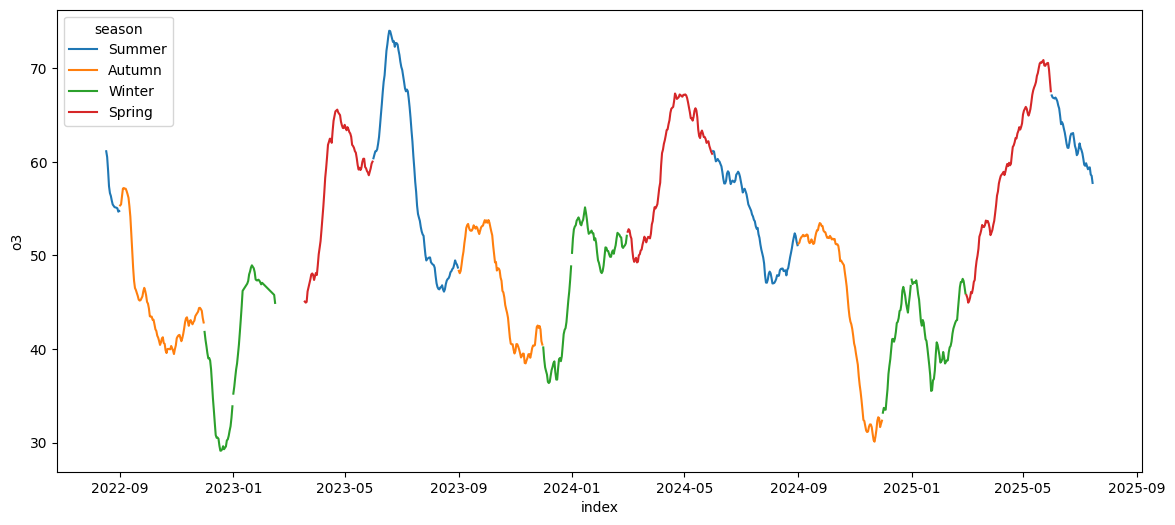

In [58]:
wind = weather_new.groupby(weather_new.index.date)['o3'].mean().rolling(window=31).mean().reset_index()
month_to_season = {
    12: 'Winter', 1: 'Winter', 2: 'Winter',
    3: 'Spring', 4: 'Spring', 5: 'Spring',
    6: 'Summer', 7: 'Summer', 8: 'Summer',
    9: 'Autumn', 10: 'Autumn', 11: 'Autumn'
}

wind['index'] = pd.to_datetime(wind['index'])
wind['month'] = wind['index'].dt.month
wind['year'] = wind['index'].dt.year
wind['season'] = wind['month'].map(month_to_season)

wind['season_block'] = (wind['season'].ne(wind['season'].shift()) | wind['year'].ne(wind['year'].shift())).cumsum()
plt.figure(figsize=(14,6))
sns.lineplot(wind, x='index', y='o3', hue='season', units='season_block')
plt.show()



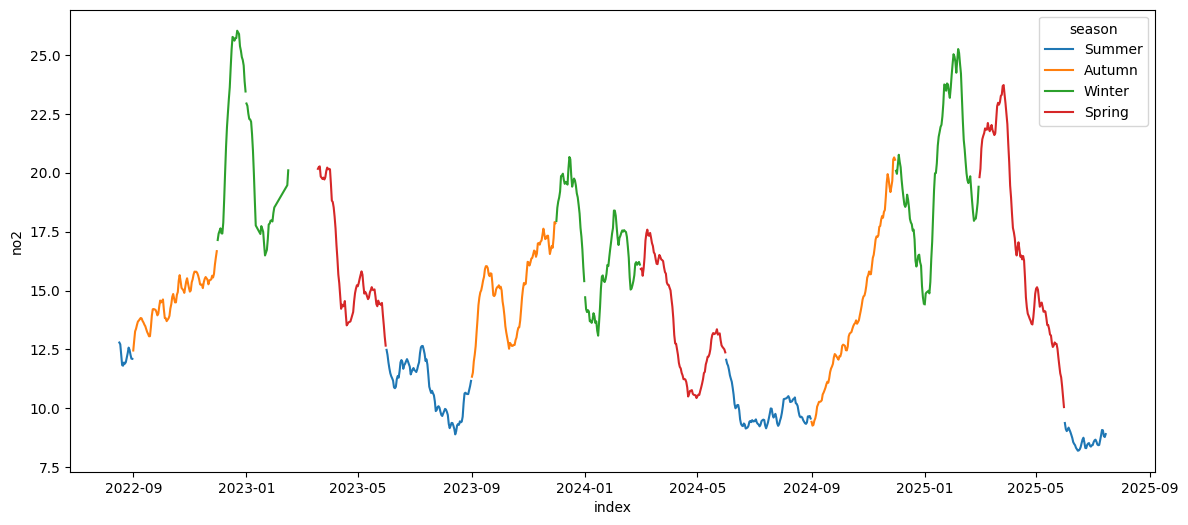

In [59]:
wind = weather_new.groupby(weather_new.index.date)['no2'].mean().rolling(window=31).mean().reset_index()
month_to_season = {
    12: 'Winter', 1: 'Winter', 2: 'Winter',
    3: 'Spring', 4: 'Spring', 5: 'Spring',
    6: 'Summer', 7: 'Summer', 8: 'Summer',
    9: 'Autumn', 10: 'Autumn', 11: 'Autumn'
}

wind['index'] = pd.to_datetime(wind['index'])
wind['month'] = wind['index'].dt.month
wind['year'] = wind['index'].dt.year
wind['season'] = wind['month'].map(month_to_season)

wind['season_block'] = (wind['season'].ne(wind['season'].shift()) | wind['year'].ne(wind['year'].shift())).cumsum()
plt.figure(figsize=(14,6))
sns.lineplot(wind, x='index', y='no2', hue='season', units='season_block')
plt.show()




There is a lot to unpack here, but first we need to using a rolling average instead of observing the data raw. This is because there is a lot of noise in data and so it would be more suitable if we used a rolling average to give us the patterns in full perspective. 

### PM2.5:
One would assume that PM2.5 would be highest during summer, however that is not the case here. It's safe to assume that during winter, households will turn on their heater which in turn will create greenhouse gasses since there is more demand for fuel. And of course during summer the polutant drops as there is no longer a need for heating. Furthermore, strangely the spring of 2025 had very high PM2.5. 

Why, you may ask? 

Well the truth is, there were several vegetation fires in early April 2025 which contributes to increase in fine particulate matter.

### O₃:

It's common for O₃ levels to peak during spring due to the increasing sunlight after winter and lower NO emissions compared to summer. However for mid-latitude regions, the peak may occur during summer

### NO2:



<div style="background-image: url('https://www.esa.int/var/esa/storage/images/esa_multimedia/videos/2021/04/earth_views_from_space_1_hour_long_in_4k/23240791-1-eng-GB/Earth_views_from_space_1_hour_long_in_4K_pillars.jpg');
            background-size: cover;
            background-position: center;
            height: 200px;
            border-radius: 15px;
            display: flex;
            align-items: center;
            justify-content: center;
            position: relative;">
    <div style="background: rgba(0,0,0,0.3); 
                padding: 20px; 
                border-radius: 10px; 
                color: white;
                text-align: center;">
        <h1 style="margin: 0;">1. Developing the Model</h1>
    </div>
</div>



In [60]:

weather_new['time'] = weather_new.index


In [61]:
weather_new['pm25'] = np.log1p(weather_new['pm25'])
weather_new['o3'] = np.log1p(weather_new['o3'])
lags = [1, 2, 3, 6, 12, 24]
features_add = []
removal = []
polutant = ['o3', 'pm25']
for pol in polutant:
    for lag in lags:
        weather_new[f'{pol}_lag_{lag}'] = weather_new.groupby(['station'])[f'{pol}'].shift(lag)
        weather_new[f'time_shift_{lag}'] = weather_new.groupby('station')['time'].shift(lag)
        time_diff = weather_new['time'] - weather_new[f'time_shift_{lag}']
        weather_new.loc[time_diff > pd.Timedelta(hours=lag), f'{pol}_lag_{lag}'] = np.nan
        removal.append(f'time_shift_{lag}')
        features_add.append(f'{pol}_lag_{lag}')
        
rollings = [1, 2, 3, 6, 12, 24]
polutant = ['pm25', 'o3']
for pol in polutant:
    for roll in rollings:
        weather_new[f'{pol}_rolling_{roll}'] = weather_new.groupby('station')[f'{pol}'].rolling(f'{roll}h', min_periods=1).mean().reset_index(level=0, drop=True)
        features_add.append(f'{pol}_rolling_{roll}')
        

for pol in polutant:
    for roll in rollings:
        weather_new[f'{pol}_rolling_std_{roll}'] = weather_new.groupby('station')[f'{pol}'].rolling(f'{roll}h', min_periods=1).std().reset_index(level=0, drop=True)
        features_add.append(f'{pol}_rolling_std_{roll}')


for pol in polutant:
    for roll in rollings:
        weather_new[f'{pol}_rolling_min_{roll}'] = weather_new.groupby('station')[f'{pol}'].rolling(f'{roll}h', min_periods=1).min().reset_index(level=0, drop=True)
        features_add.append(f'{pol}_rolling_min_{roll}')


for pol in polutant:
    for roll in rollings:
        weather_new[f'{pol}_rolling_max_{roll}'] = weather_new.groupby('station')[f'{pol}'].rolling(f'{roll}h', min_periods=1).max().reset_index(level=0, drop=True)
        features_add.append(f'{pol}_rolling_max_{roll}')

weather_new.drop(removal, axis=1, inplace=True)
weather_new

station   no2        o3      pm25  \
time                                                                  
2022-07-17 00:00:00+00:00  Belfast Centre  14.0  3.784190  2.079442   
2022-07-17 01:00:00+00:00  Belfast Centre  16.0  3.713572  2.079442   
2022-07-17 02:00:00+00:00  Belfast Centre  17.0  3.688879  2.079442   
2022-07-17 03:00:00+00:00  Belfast Centre  17.0  3.688879  2.079442   
2022-07-17 04:00:00+00:00  Belfast Centre   9.0  3.713572  2.079442   
...                                   ...   ...       ...       ...   
2025-07-15 11:00:00+00:00    York Bootham   7.0  3.663562       NaN   
2025-07-15 12:00:00+00:00    York Bootham   7.0  3.663562       NaN   
2025-07-15 13:00:00+00:00    York Bootham   7.0  3.583519       NaN   
2025-07-15 14:00:00+00:00    York Bootham   7.0  3.583519       NaN   
2025-07-15 16:00:00+00:00    York Bootham   7.0  3.496508       NaN   

                           wind_speed_10m  wind_direction_10m  temperature_2m  \
time                                                                            
2022-07-17 00:00:00+00:00        5.154415          114.775116       14.488000   
2022-07-17 01:00:00+00:00        4.680000          112.619910       13.938001   
2022-07-17 02:00:00+00:00        6.439876          153.435010       14.438001   
2022-07-17 03:00:00+00:00        7.172949          197.525670       14.888001   
2022-07-17 04:00:00+00:00        5.623380          140.194470       14.888001   
...                                   ...                 ...             ...   
2025-07-15 11:00:00+00:00       15.137133          177.273740       16.161001   
2025-07-15 12:00:00+00:00       18.643690          169.992080       16.811000   
2025-07-15 13:00:00+00:00       22.528780          172.193700       15.361000   
2025-07-15 14:00:00+00:00       24.332644          177.031830       15.111000   
2025-07-15 16:00:00+00:00       21.869816          185.194340       17.261000   

                           relative_humidity_2m  precipitation  rain  ...  \
time                                                                  ...   
2022-07-17 00:00:00+00:00             86.647680            0.0   0.0  ...   
2022-07-17 01:00:00+00:00             84.056150            0.0   0.0  ...   
2022-07-17 02:00:00+00:00             78.723180            0.0   0.0  ...   
2022-07-17 03:00:00+00:00             77.751450            1.1   1.1  ...   
2022-07-17 04:00:00+00:00             81.976660            1.3   1.3  ...   
...                                         ...            ...   ...  ...   
2025-07-15 11:00:00+00:00             80.542470            1.1   1.1  ...   
2025-07-15 12:00:00+00:00             76.275190            0.3   0.3  ...   
2025-07-15 13:00:00+00:00             92.257970            1.6   1.6  ...   
2025-07-15 14:00:00+00:00             91.052956            1.0   1.0  ...   
2025-07-15 16:00:00+00:00             78.876480            0.1   0.1  ...   

                           pm25_rolling_max_3  pm25_rolling_max_6  \
time                                                                
2022-07-17 00:00:00+00:00            2.079442            2.079442   
2022-07-17 01:00:00+00:00            2.079442            2.079442   
2022-07-17 02:00:00+00:00            2.079442            2.079442   
2022-07-17 03:00:00+00:00            2.079442            2.079442   
2022-07-17 04:00:00+00:00            2.079442            2.079442   
...                                       ...                 ...   
2025-07-15 11:00:00+00:00                 NaN                 NaN   
2025-07-15 12:00:00+00:00                 NaN                 NaN   
2025-07-15 13:00:00+00:00                 NaN                 NaN   
2025-07-15 14:00:00+00:00                 NaN                 NaN   
2025-07-15 16:00:00+00:00                 NaN                 NaN   

                           pm25_rolling_max_12  pm25_rolling_max_24  \
time                                                                  
2022-07-17 00:

In [62]:

weather_pm25_clean = weather_new.drop(
    ['no2', 'o3', 'o3_lag_1', 'o3_lag_2', 'o3_lag_3', 'o3_lag_6','o3_lag_12','o3_lag_24', 'date', 'o3_rolling_1', 'o3_rolling_2', 'o3_rolling_3', 'o3_rolling_6', 'o3_rolling_12', 'o3_rolling_24',
     'o3_rolling_min_1', 'o3_rolling_min_2', 'o3_rolling_min_3', 'o3_rolling_min_6', 'o3_rolling_min_12', 'o3_rolling_min_24', 'o3_rolling_max_1', 'o3_rolling_max_2', 'o3_rolling_max_3', 'o3_rolling_max_6', 'o3_rolling_max_12', 'o3_rolling_max_24',
     'o3_rolling_std_1', 'o3_rolling_std_2', 'o3_rolling_std_3', 'o3_rolling_std_6', 'o3_rolling_std_12', 'o3_rolling_std_24'],
    axis=1
)




In [63]:

weather_o3_clean = weather_new.drop(
        ['no2', 'pm25', 'pm25_lag_1', 'pm25_lag_2', 'pm25_lag_3', 'pm25_lag_6','pm25_lag_12','pm25_lag_24', 'date', 'pm25_rolling_3', 'pm25_rolling_6', 'pm25_rolling_12', 'pm25_rolling_24',
     'pm25_rolling_min_3', 'pm25_rolling_min_6', 'pm25_rolling_min_12', 'pm25_rolling_min_24', 'pm25_rolling_max_3', 'pm25_rolling_max_6', 'pm25_rolling_max_12', 'pm25_rolling_max_24','pm25_rolling_std_2', 'pm25_rolling_max_1', 'pm25_rolling_max_2', 'pm25_rolling_min_1', 'pm25_rolling_min_2',
     'pm25_rolling_std_3', 'pm25_rolling_std_6', 'pm25_rolling_std_12', 'pm25_rolling_std_24', 'pm25_rolling_2', 'pm25_rolling_1', 'pm25_rolling_std_1'],
    axis=1
)



In [64]:
def preprocess_df(df, pollutant, split, lower, upper):
    lower, upper = np.log1p(lower), np.log1p(upper)
    dataframe = df
    dataframe[f'{pollutant}_target_t_plus_12'] = dataframe.groupby('station')[f'{pollutant}'].shift(-12)
    weather_clean = dataframe.dropna(
    subset=[f'{pollutant}', f'{pollutant}_target_t_plus_12']
)

    weather_clean = weather_clean.sort_index()
    y = weather_clean[f'{pollutant}_target_t_plus_12']
    X = weather_clean.drop([f'{pollutant}_target_t_plus_12', 'time'], axis=1)

    # Create split 
    start_date = X.index.min()
    end_date = X.index.max()
    total_duration = end_date - start_date
    split_date = start_date + (total_duration * split)

    print(f"Split date: {split_date}")

    # Create temporal masks
    train_mask = X.index <= split_date
    test_mask = y.index > split_date

    X_train = X[train_mask]
    y_train = y[train_mask]
    X_test = X[test_mask]
    y_test = y[test_mask]

    
    print(f"Training period: {X_train.index.min()} to {X_train.index.max()}")
    print(f"Test period: {X_test.index.min()} to {X_test.index.max()}")
    print(f"Training samples: {len(X_train)} ({len(X_train)/len(X):.1%})")
    print(f"Test samples: {len(X_test)} ({len(X_test)/len(X):.1%})")

    # Filter sensor errors for training set
    outlier = (y_train <= lower) | (y_train > upper)
    y_train = y_train[~outlier]
    X_train = X_train[~outlier]

    # Filter sensor errors for test set
    outlier = (y_test <= lower) | (y_test > upper)
    y_test = y_test[~outlier]
    X_test = X_test[~outlier]

    #Log target so less susceptible to outliers
    y_train_log = y_train
    
    #Prepare persistance model
    # print(y_presistance.isna().sum())
    y_presistance = y[test_mask]
    y_presistance = y_presistance[~outlier]
    
    return X_train, y_train_log, X_test, y_test, y_test, y_test
# X_pm25_train, y_pm25_train_log, X_pm25_test, y_pm25_test, y_pm25_true_test, y_pm25_pred_persistence_test = preprocess_df(weather_pm25_clean, 'pm25',0.66, lower  = 1.01, upper = 150)


In [65]:
X_pm25_train, y_pm25_train_log, X_pm25_test, y_pm25_test, y_pm25_pred_persistence_test, y_pm25_true_test = preprocess_df(weather_pm25_clean, 'pm25',0.66, lower  = 1.01, upper = 150)
X_o3_train, y_o3_train_log, X_o3_test, y_o3_test, y_o3_pred_persistence_test, y_true_test = preprocess_df(weather_o3_clean, 'o3', 0.66, lower  = 2.1, upper = 1000)

Split date: 2024-07-08 07:33:36+00:00
Training period: 2022-07-17 00:00:00+00:00 to 2024-07-08 07:00:00+00:00
Test period: 2024-07-08 08:00:00+00:00 to 2025-07-15 10:00:00+00:00
Training samples: 705346 (72.1%)
Test samples: 272535 (27.9%)
Split date: 2024-07-08 08:13:12+00:00
Training period: 2022-07-17 00:00:00+00:00 to 2024-07-08 08:00:00+00:00
Test period: 2024-07-08 09:00:00+00:00 to 2025-07-15 11:00:00+00:00
Training samples: 662378 (67.2%)
Test samples: 323654 (32.8%)


In [55]:
import pickle
pickle.dump(X_pm25_test, open('X_pm25_test.p', 'wb'))
pickle.dump(y_pm25_test, open('y_pm25_test.p', 'wb'))

What we're doing here is preparing the benchmark of our project, the aim here is to beat the persistence baseline

<div style="background: linear-gradient(90deg, #34495e 0%, #2c3e50 100%);
            height: 50px;
            border-radius: 8px;
            display: flex;
            align-items: center;
            padding-left: 20px;
            box-shadow: 0 1px 4px rgba(0,0,0,0.1);">
    <h3 style="margin: 0; 
               color: #ecf0f1; 
               font-size: 1.05em; 
               font-weight: 400;">
        1.1 Developing the Model to Predict PM2.5
    </h3>
</div>

Now, what we essentially want here is to create a baseline, this baseline is what we hope to beat through tuning.

In [ ]:
# xg_reg_pm25 = xgb.XGBRegressor(objective='reg:squarederror',
#                           colsample_bytree = 1, 
#                           learning_rate = 0.3,
#                           max_depth = 15, 
#                           alpha = 10, 
#                           n_estimators = 100, 
#                           verbose=1, 
#                           min_child_weight = 1,
#                           colsample_bylevel = 1, 
#                           reg_alpha = 2)

In [ ]:
# validation_results = []
# for fold, (train_idx, test_idx) in enumerate(tscv.split(X_pm25_train)):
#     print("Fold: {}".format(fold))
#     print("TRAIN indices:", train_idx, "\n", "TEST indices:", test_idx)
#     X_train, X_test = X_pm25_train.iloc[train_idx], X_pm25_train.iloc[test_idx]
#     y_train, y_test = y_pm25_train.iloc[train_idx], y_pm25_train.iloc[test_idx]
    
    
    
#     encoder = ce.TargetEncoder(cols=['station', 'day_of_week'], handle_unknown='return_nan', handle_missing='return_nan')
#     X_train = encoder.fit_transform(X_train, y_train)
#     X_test = encoder.transform(X_test)
    
#     xg_reg_pm25.fit(X_train, y_train,
#                eval_set=[(X_test, y_test)],
#                verbose=True)
#     validation_results.append(xg_reg_pm25.evals_result())



In [ ]:
# unpacked_results = [res['validation_0']['rmse'] for res in validation_results]
# sns.lineplot(unpacked_results)
# plt.xlabel('Iterations')
# plt.ylabel('RMSE')
# plt.title('RMSE During Training - All Folds')
# plt.show()

The RMSE is decent for random hyperparameters, however this is not adequate for predicting PM2.5 as the range is between 4-9 PM2.5 and so that is quite a large jump. Therefore to improve this we will be tuning our model using Optuna.



<div style="background-image: url('https://www.esa.int/var/esa/storage/images/esa_multimedia/videos/2021/04/earth_views_from_space_1_hour_long_in_4k/23240791-1-eng-GB/Earth_views_from_space_1_hour_long_in_4K_pillars.jpg');
            background-size: cover;
            background-position: center;
            height: 200px;
            border-radius: 15px;
            display: flex;
            align-items: center;
            justify-content: center;
            position: relative;">
    <div style="background: rgba(0,0,0,0.3); 
                padding: 20px; 
                border-radius: 10px; 
                color: white;
                text-align: center;">
        <h1 style="margin: 0;">1. Tuning hyperparameters</h1>
    </div>
</div>



In [ ]:
n_splits = 3 # reducing the amount of folds to speed up tuning
tscv = TimeSeriesSplit(n_splits)
#{'lambda': 7.019586323585372, 'alpha': 3.470246677131541, 'colsample_bytree': 0.5, 'colsample_bylevel': 1.0, 'subsample': 1.0, 'learning_rate': 0.04651614023514727, 'n_estimators': 878, 'max_depth': 11, 'min_child_weight': 1}
# {'lambda': 9.840040949863173, 'alpha': 5.091480948913947, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.5, 'subsample': 1.0, 'learning_rate': 0.0158465614994074, 'n_estimators': 1725, 'max_depth': 13, 'min_child_weight': 1}
#{'lambda': 8.454142731565085, 'alpha': 3.984447249171694, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.5, 'subsample': 1.0, 'learning_rate': 0.015679047597583706, 'n_estimators': 1593, 'max_depth': 13, 'min_child_weight': 1}. Best is trial 152 with value:

y_pm25_train = np.expm1(y_pm25_train_log)
y_pm25_train_upper = y_pm25_train[y_pm25_train > 12]
X_pm25_train_upper = X_pm25_train.loc[y_pm25_train > 12]
def objective(trial, data=X_pm25_train_upper, target=y_pm25_train_upper):
    param = {
        'objective': 'reg:quantileerror',
        'alpha': trial.suggest_loguniform('alpha', 2, 7),
        'quantile_alpha': trial.suggest_float('quantile_alpha', 0.8, 0.99),  # good for peaks
        'lambda': trial.suggest_loguniform('lambda', 2, 10),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.5, 0.7, 0.9, 1.0]),
        'colsample_bylevel': trial.suggest_categorical('colsample_bylevel', [0.5, 0.7, 0.9, 1.0]),
        'subsample': 1.0,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 800, 2000),
        'max_depth': trial.suggest_categorical('max_depth', [10, 11, 13]),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 20),
        'random_state': 42,
        'early_stopping_rounds': 50,
        'tree_method': 'gpu_hist',
        'predictor': 'gpu_predictor'
    }
    
    rmse_list = []
    for fold, (train_idx, val_idx) in enumerate(tscv.split(data)):
        X_train = data.iloc[train_idx]
        y_train = target.iloc[train_idx]

        X_val = data.iloc[val_idx]
        y_val = target.iloc[val_idx]
        encoder = ce.TargetEncoder(cols=['station', 'day_of_week'], handle_unknown='return_nan', handle_missing='return_nan')
        X_train = encoder.fit_transform(X_train, y_train)

        X_val = encoder.transform(X_val)
    
        model = xgb.XGBRegressor(**param)
        model.fit(X_train, y_train,
            eval_set=[(X_val, y_val)],
            verbose=False)
        predicted = model.predict(X_val)
        rmse = root_mean_squared_error(y_val, predicted)
        rmse_list.append(rmse)
    return np.mean(rmse_list)


In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=200)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

This took a bit longer than expected, especially when the max depth of the tree increased causing longer training time. I left the tuning overnight and ended up with 2.04 MSE, despite this i decided to interrupt the training as it would have taken days to complete 1000 trials 

Fold: 0
TRAIN indices: [     0      1      2 ... 116463 116464 116465] 
 TEST indices: [116466 116467 116468 ... 232924 232925 232926]


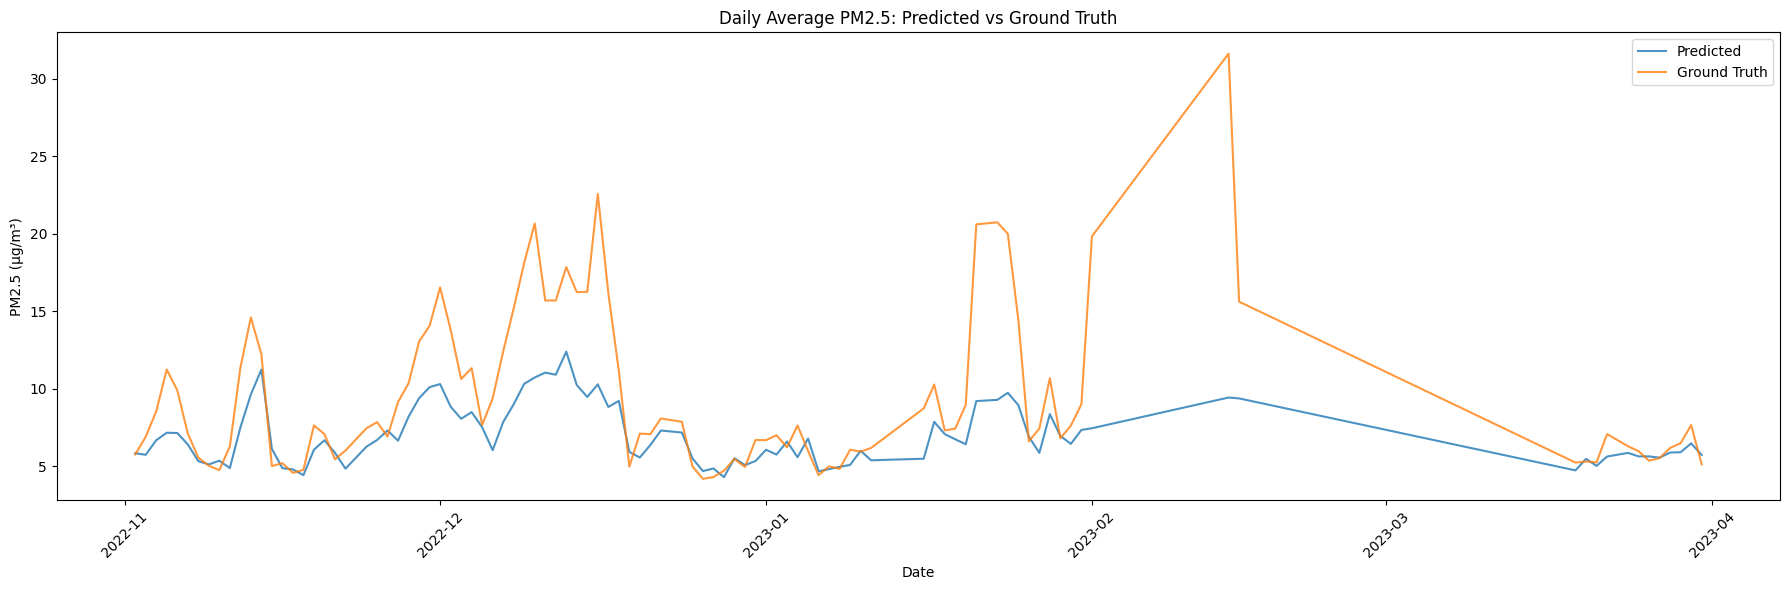

5.9902352681530076
Fold: 1
TRAIN indices: [     0      1      2 ... 232924 232925 232926] 
 TEST indices: [232927 232928 232929 ... 349385 349386 349387]


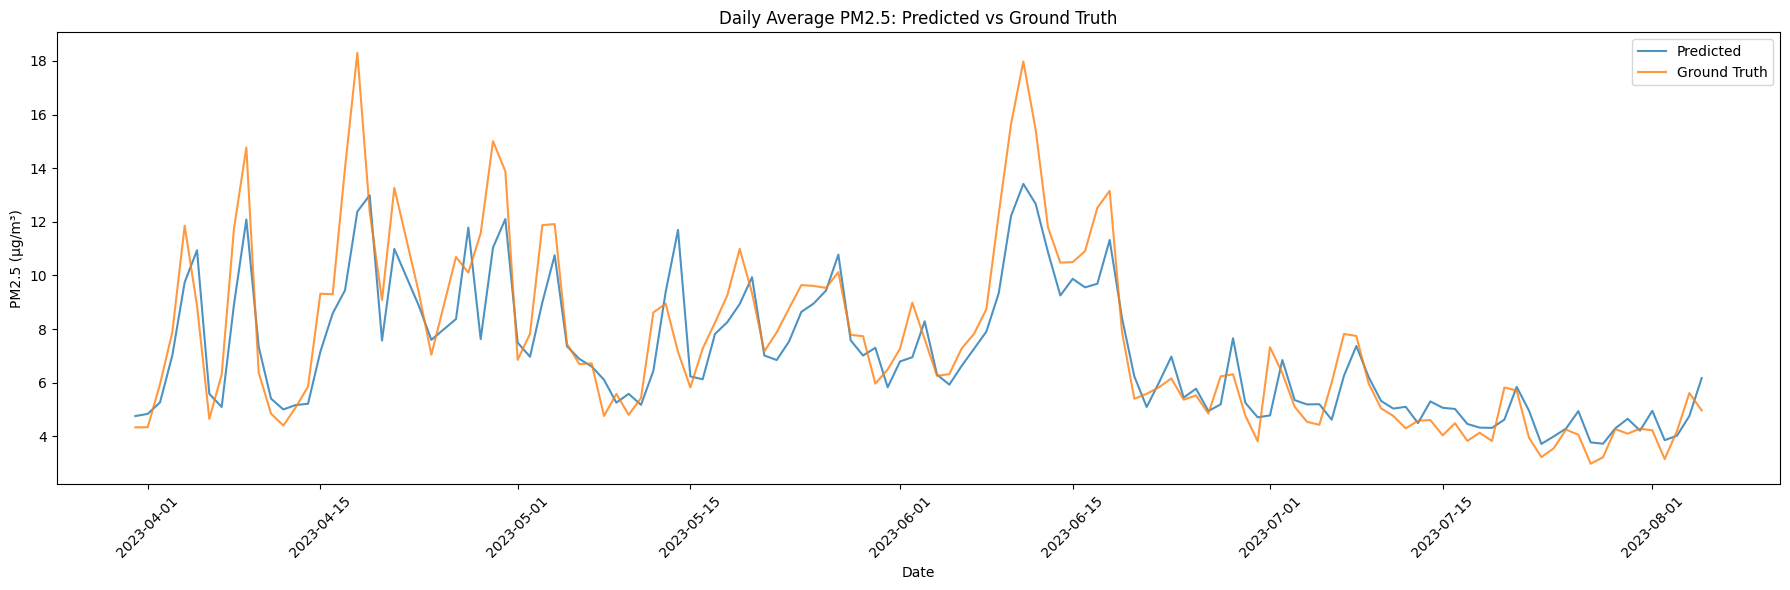

2.9109792587057273
Fold: 2
TRAIN indices: [     0      1      2 ... 349385 349386 349387] 
 TEST indices: [349388 349389 349390 ... 465846 465847 465848]


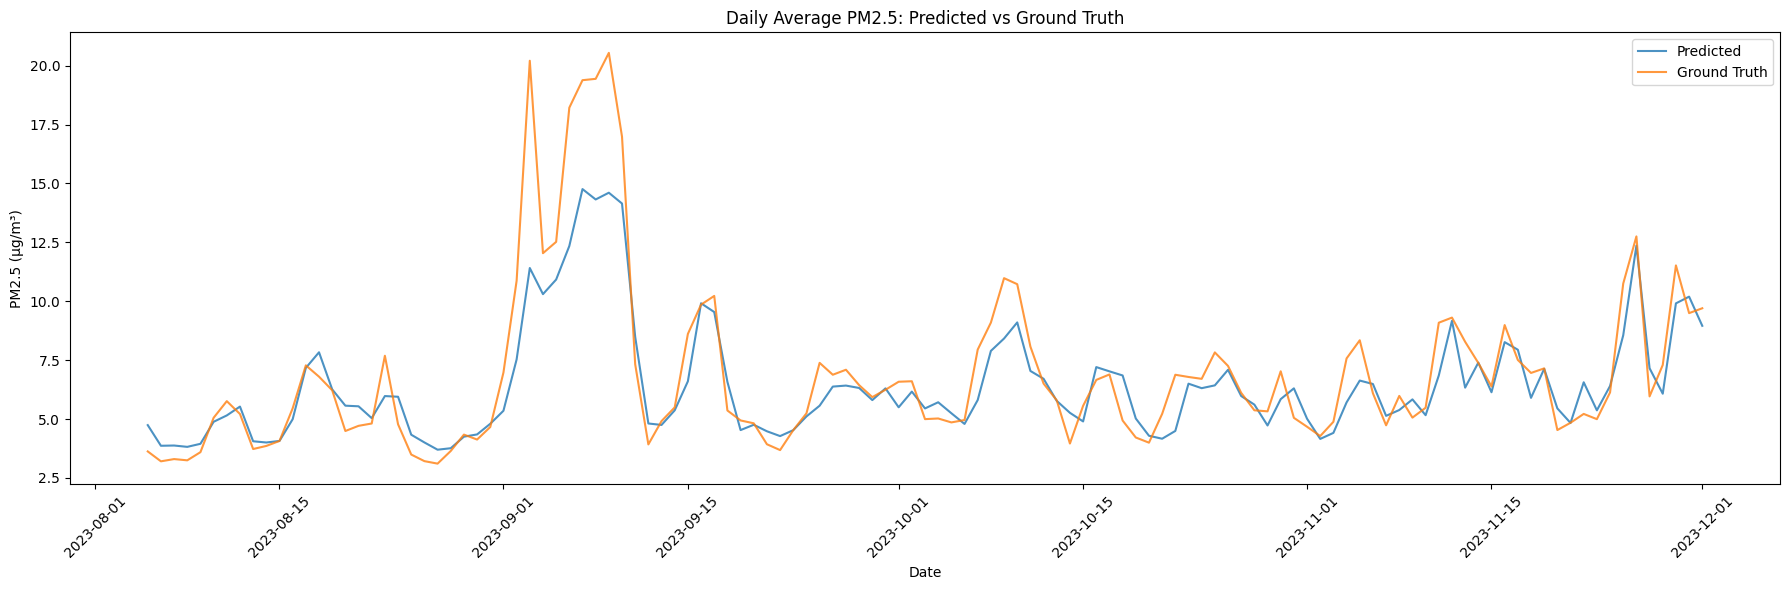

3.065992835642154
Fold: 3
TRAIN indices: [     0      1      2 ... 465846 465847 465848] 
 TEST indices: [465849 465850 465851 ... 582307 582308 582309]


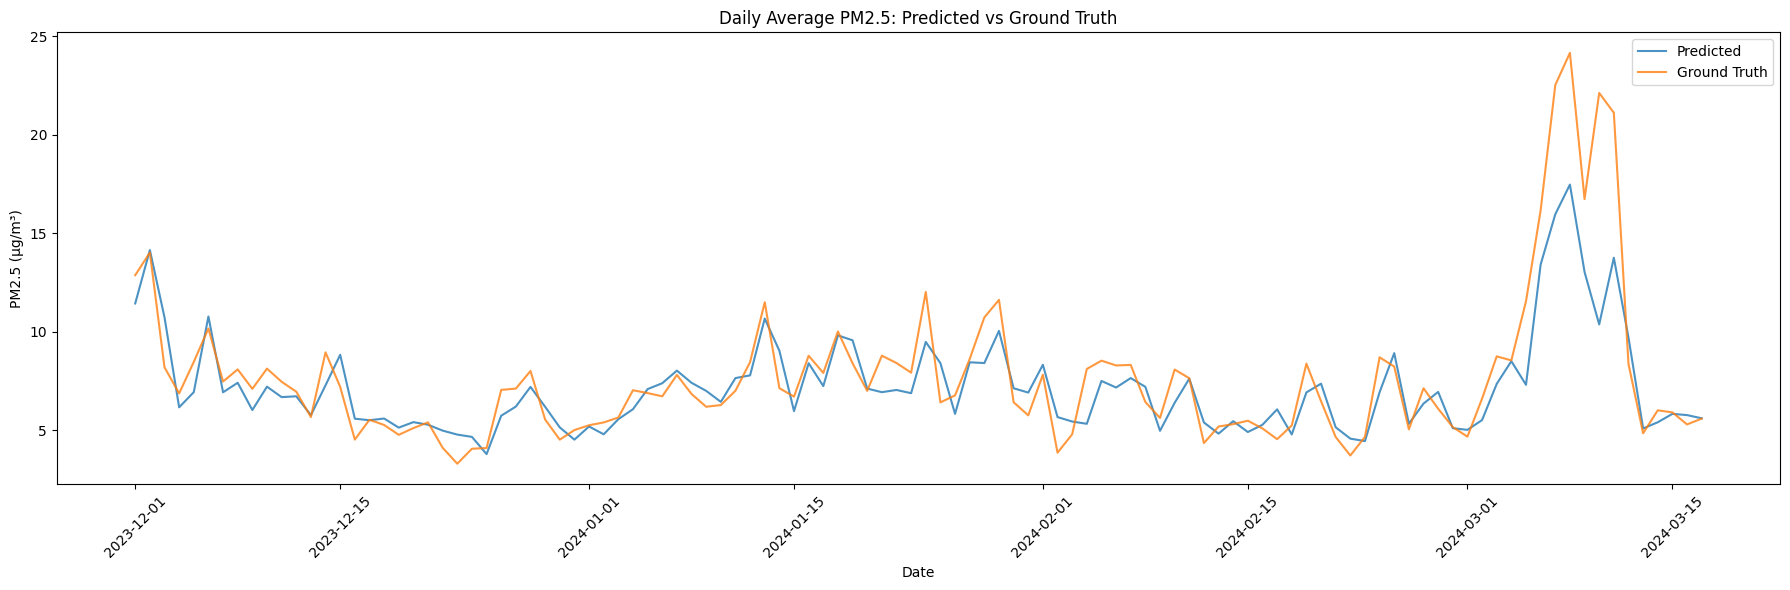

3.1795730517047085
Fold: 4
TRAIN indices: [     0      1      2 ... 582307 582308 582309] 
 TEST indices: [582310 582311 582312 ... 698768 698769 698770]


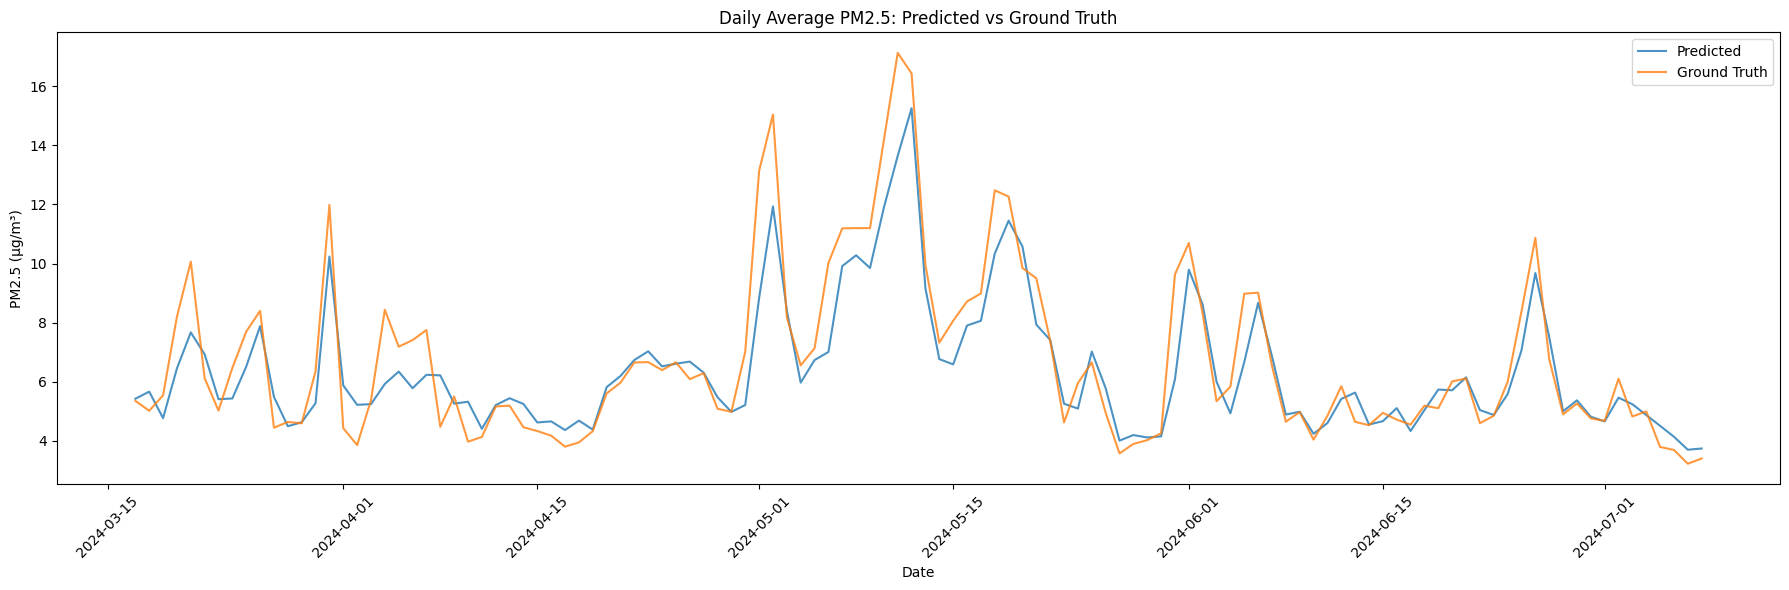

2.5461237714948117


In [79]:
n_splits = 5
tscv = TimeSeriesSplit(n_splits)

#{'alpha': 2.718725070863653, 'quantile_alpha': 0.7507345239692093, 'lambda': 9.979213030002173, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.5, 'learning_rate': 0.05793723477706892, 'n_estimators': 1069, 'max_depth': 13, 'min_child_weight': 12}
xg_mid = xgb.XGBRegressor(
    objective='reg:quantileerror',
    quantile_alpha=0.487,
    reg_lambda=7.59,
    reg_alpha=3.65,
    colsample_bytree=0.5,
    colsample_bylevel=0.5,
    subsample=1,
    learning_rate=0.017,
    n_estimators=1979,
    max_depth=13,
    min_child_weight=20,
    random_state=42,
    verbose=0,
    early_stopping_rounds=50,
    tree_method='gpu_hist',
    predictor='gpu_predictor'
)

validation_results = []
for fold, (train_idx, test_idx) in enumerate(tscv.split(X_pm25_train)):
    print("Fold: {}".format(fold))
    print("TRAIN indices:", train_idx, "\n", "TEST indices:", test_idx)
    
    #Slice dataframe based  on splits
    X_train, X_test = X_pm25_train.iloc[train_idx], X_pm25_train.iloc[test_idx]
    y_train, y_test = y_pm25_train_log.iloc[train_idx], y_pm25_train_log.iloc[test_idx]
    
    #Encode categorical variables
    encoder = ce.TargetEncoder(cols=['station', 'day_of_week'], handle_unknown='return_nan', handle_missing='return_nan')
    X_train = encoder.fit_transform(X_train, y_train)
    X_test = encoder.transform(X_test)
    
    #Train model and predict testing set
    xg_mid.fit(X_train, y_train,
            eval_set=[(X_test, y_test)],
            verbose=0)
    res = xg_mid.predict(X_test)
    ensemble_pred = np.expm1(res)
    
    #Create plot showing validation set progress
    df_test = pd.DataFrame({
    "date": X_test.index,   
    "pm25_predicted": ensemble_pred,
    "pm25_ground": np.expm1(y_test),
    })

    # Convert to datetime if not already
    df_test["date"] = pd.to_datetime(df_test["date"])

    # Group by day and take the mean
    daily_avg_pred = df_test.groupby(df_test["date"].dt.date)["pm25_predicted"].mean()
    daily_avg_ground = df_test.groupby(df_test["date"].dt.date)["pm25_ground"].mean()

    plt.figure(figsize=(18, 6))
    plt.plot(daily_avg_pred.index, daily_avg_pred.values, label='Predicted', alpha=0.8)
    plt.plot(daily_avg_ground.index, daily_avg_ground.values, label='Ground Truth', alpha=0.8)
    plt.xlabel('Date')
    plt.ylabel('PM2.5 (µg/m³)')
    plt.title('Daily Average PM2.5: Predicted vs Ground Truth')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    print(root_mean_squared_error(np.expm1(y_test), ensemble_pred))

    validation_results.append(xg_mid.evals_result())

# Save model
# xg_mid.save_model('xg_mid.model') 

In [70]:
print(X_pm25_train)

                                                station      pm25  \
time                                                                
2022-07-17 00:00:00+00:00                Belfast Centre  2.079442   
2022-07-17 00:00:00+00:00                       Honiton  1.609438   
2022-07-17 00:00:00+00:00                     Glazebury  1.945910   
2022-07-17 00:00:00+00:00         Edinburgh St Leonards  1.609438   
2022-07-17 00:00:00+00:00               Derry Rosemount  1.945910   
...                                                 ...       ...   
2024-07-08 07:00:00+00:00         Manchester Piccadilly  1.609438   
2024-07-08 07:00:00+00:00                Leamington Spa  1.098612   
2024-07-08 07:00:00+00:00  Greenwich - Westhorne Avenue  1.629241   
2024-07-08 07:00:00+00:00             Charlton Mackrell  1.098612   
2024-07-08 07:00:00+00:00             London Harlington  1.609438   

                           wind_speed_10m  wind_direction_10m  temperature_2m  \
time                 

Fold: 0
TRAIN indices: [     0      1      2 ... 116463 116464 116465] 
 TEST indices: [116466 116467 116468 ... 232924 232925 232926]


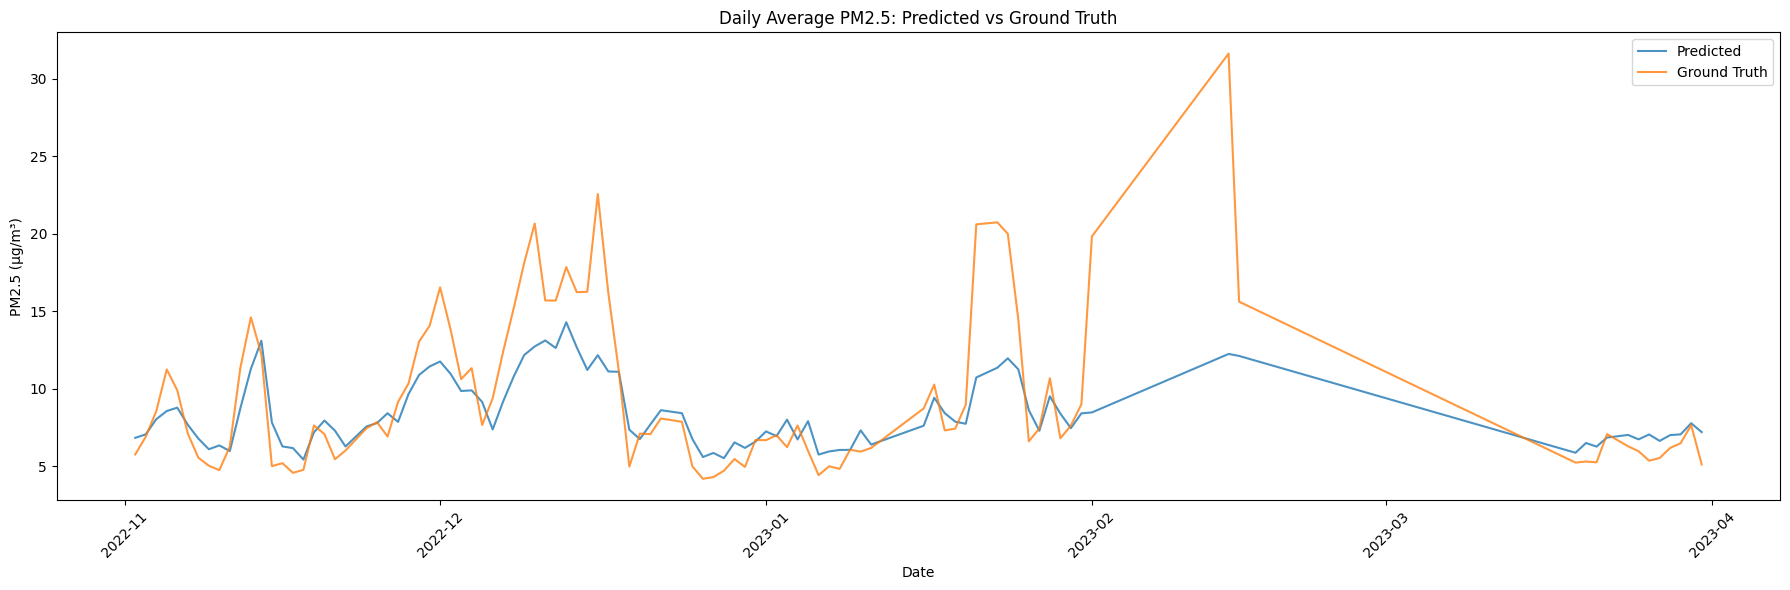

5.451154855624627
Fold: 1
TRAIN indices: [     0      1      2 ... 232924 232925 232926] 
 TEST indices: [232927 232928 232929 ... 349385 349386 349387]


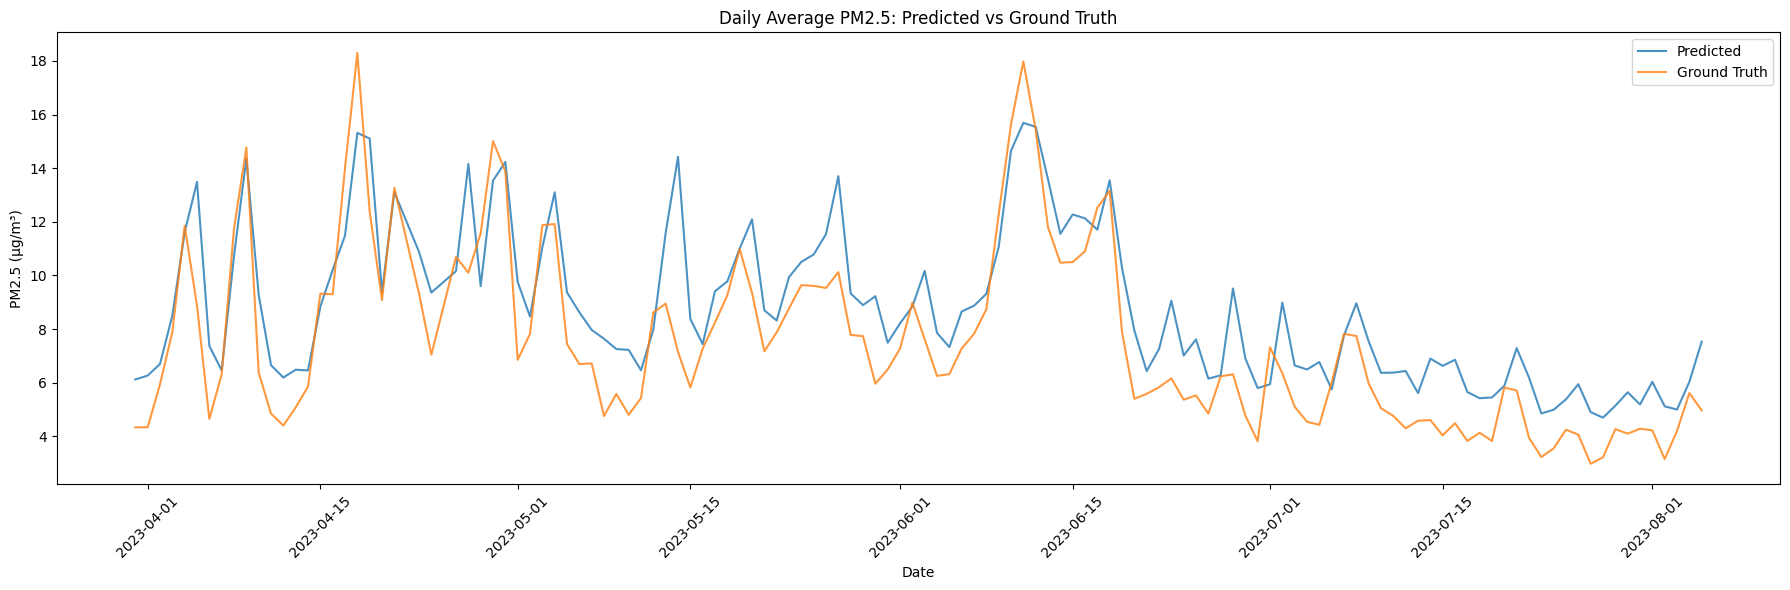

3.069949319035775
Fold: 2
TRAIN indices: [     0      1      2 ... 349385 349386 349387] 
 TEST indices: [349388 349389 349390 ... 465846 465847 465848]


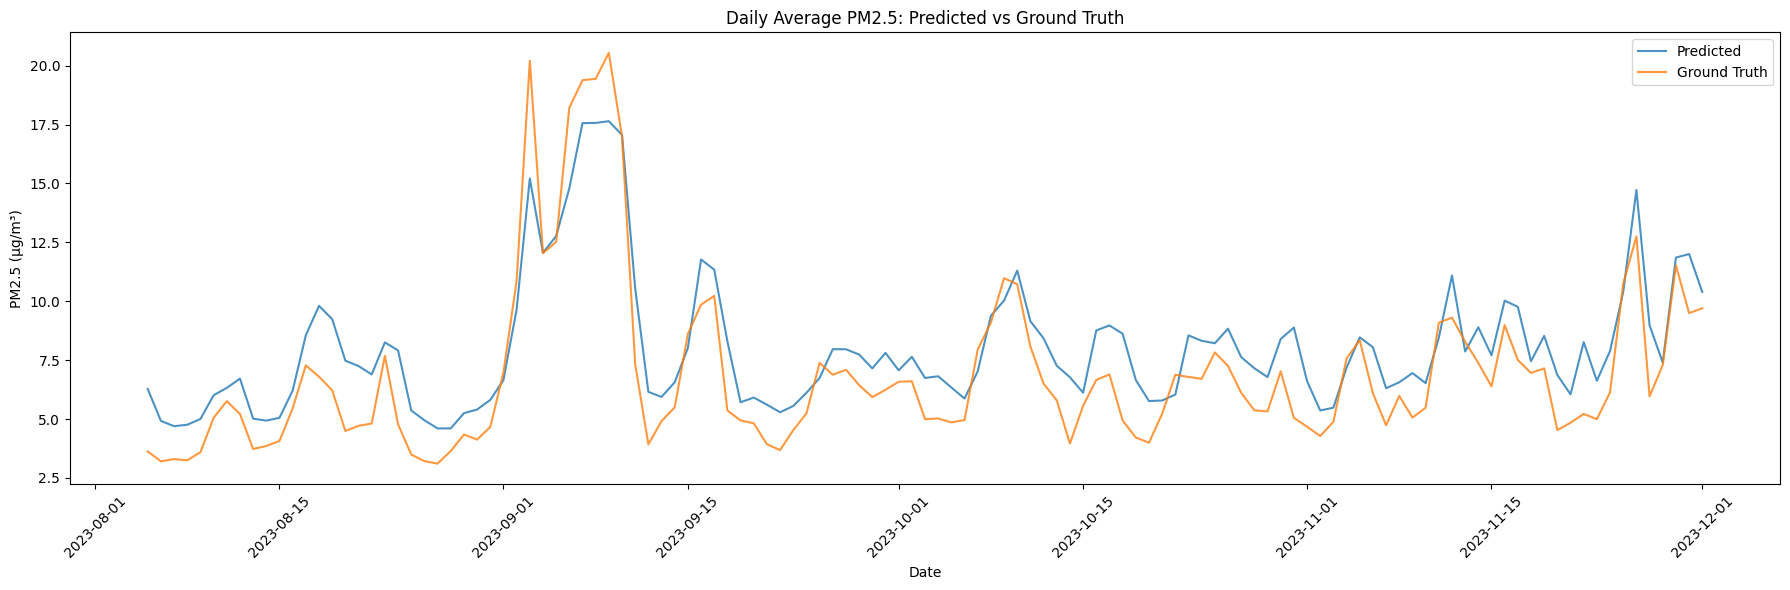

3.1238071558612317
Fold: 3
TRAIN indices: [     0      1      2 ... 465846 465847 465848] 
 TEST indices: [465849 465850 465851 ... 582307 582308 582309]


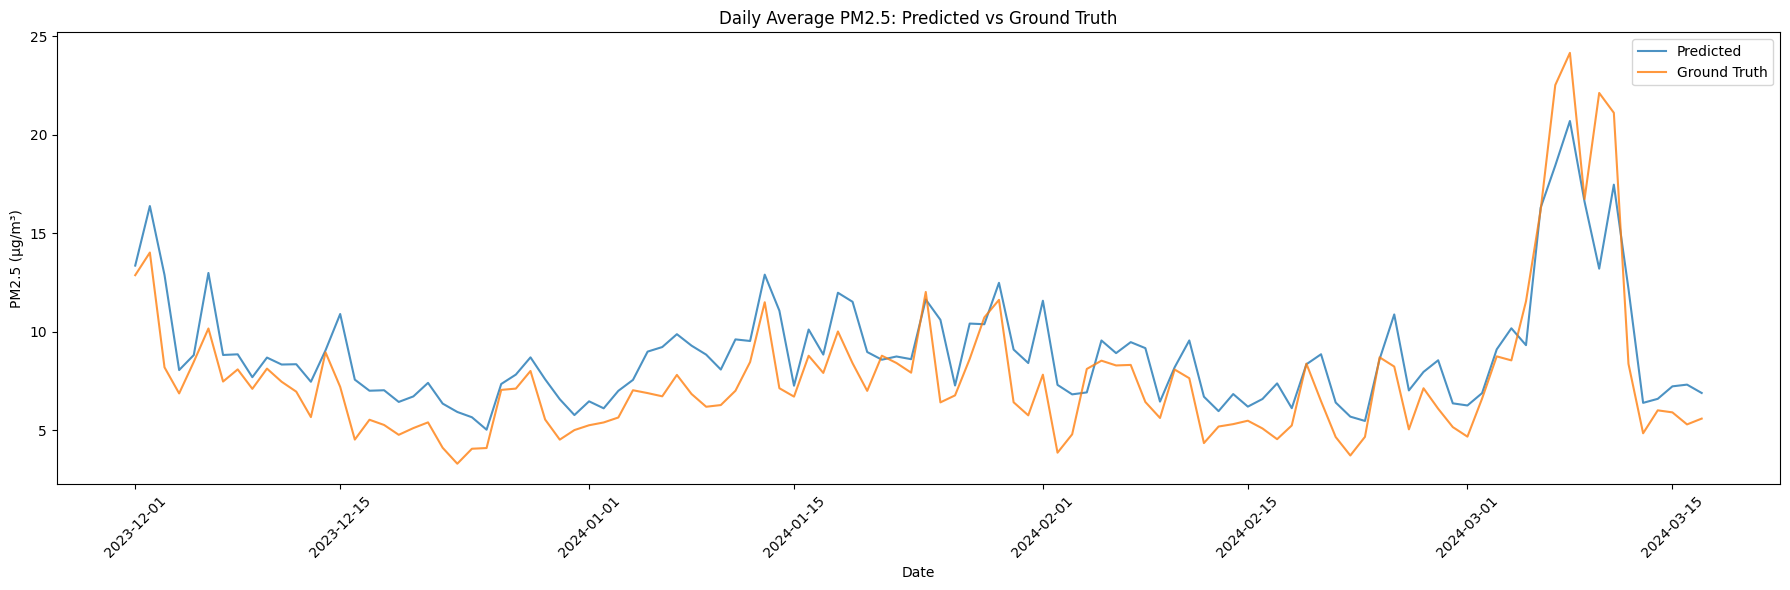

3.3744685889386203
Fold: 4
TRAIN indices: [     0      1      2 ... 582307 582308 582309] 
 TEST indices: [582310 582311 582312 ... 698768 698769 698770]


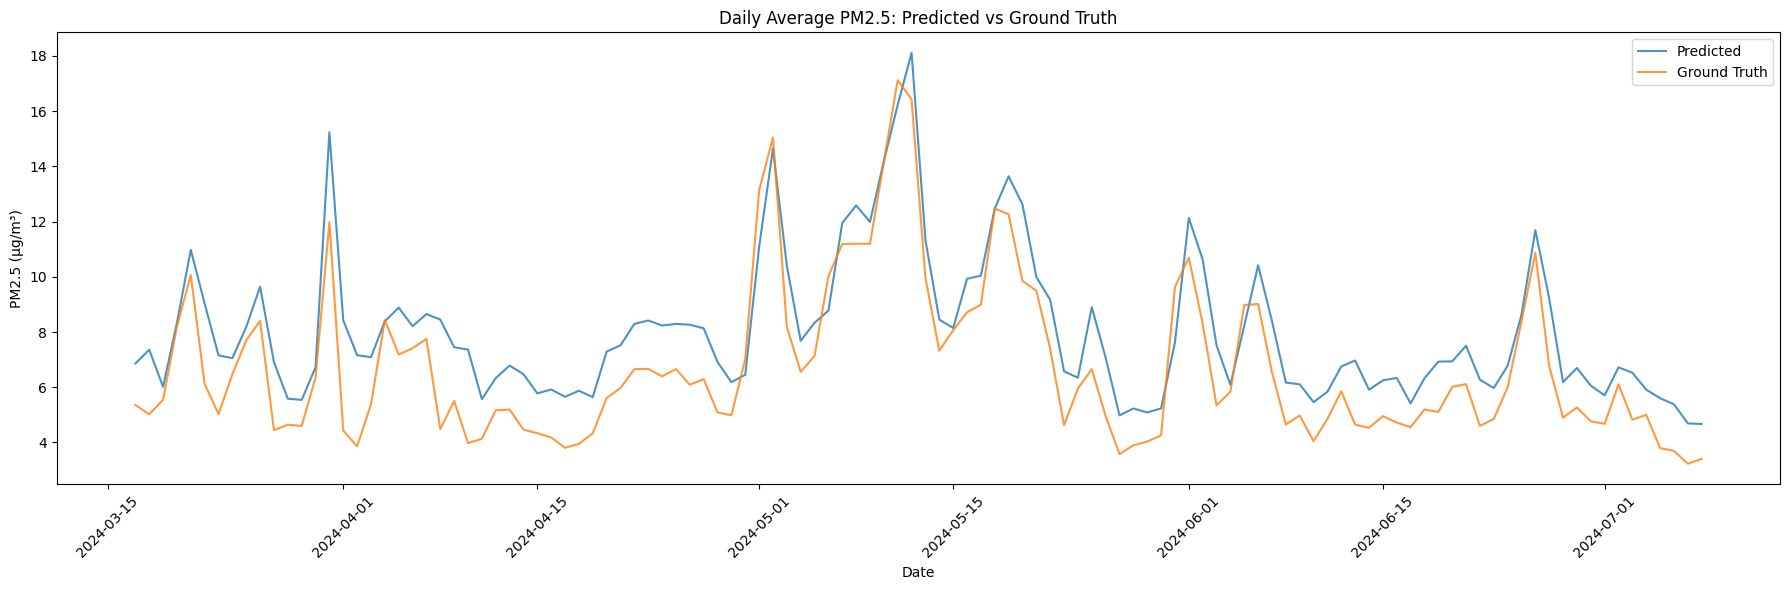

2.7788763018859637


In [78]:
n_splits = 5
tscv = TimeSeriesSplit(n_splits)

#{'alpha': 4.101844277859214, 'quantile_alpha': 0.8001088748756277, 'lambda': 4.336133542532513, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.5, 'learning_rate': 0.015458111541603124, 'n_estimators': 1002, 'max_depth': 11, 'min_child_weight': 18}
xg_90 = xgb.XGBRegressor(
    objective='reg:quantileerror',
    quantile_alpha=0.80010,
    reg_lambda=4.336,
    reg_alpha=4.101844277859214,
    colsample_bytree=0.5,
    colsample_bylevel=0.5,
    subsample=1,
    learning_rate=0.0154581,
    n_estimators=1002,
    max_depth=11,
    min_child_weight=18,
    random_state=42,
    verbose=0,
    early_stopping_rounds=50,
    tree_method='gpu_hist',
    predictor='gpu_predictor'
)

validation_results = []
for fold, (train_idx, test_idx) in enumerate(tscv.split(X_pm25_train)):
    print("Fold: {}".format(fold))
    print("TRAIN indices:", train_idx, "\n", "TEST indices:", test_idx)
    X_train, X_test = X_pm25_train.iloc[train_idx], X_pm25_train.iloc[test_idx]
    y_train, y_test = y_pm25_train_log.iloc[train_idx], y_pm25_train_log.iloc[test_idx]
    

    encoder = ce.TargetEncoder(cols=['station', 'day_of_week'], handle_unknown='return_nan', handle_missing='return_nan')
    X_train = encoder.fit_transform(X_train, y_train)
    X_test = encoder.transform(X_test)
    
    xg_90.fit(X_train, y_train,
            eval_set=[(X_test, y_test)],
            verbose=0)
    res = xg_90.predict(X_test)
    ensemble_pred = np.expm1(res)
    df_test = pd.DataFrame({
    "date": X_test.index,   # replace "date" with your actual datetime column name
    "pm25_predicted": ensemble_pred,
    "pm25_ground": np.expm1(y_test),
    })

    # Convert to datetime if not already
    df_test["date"] = pd.to_datetime(df_test["date"])

    # Group by day and take the mean
    daily_avg_pred = df_test.groupby(df_test["date"].dt.date)["pm25_predicted"].mean()
    daily_avg_ground = df_test.groupby(df_test["date"].dt.date)["pm25_ground"].mean()

    plt.figure(figsize=(18, 6))
    plt.plot(daily_avg_pred.index, daily_avg_pred.values, label='Predicted', alpha=0.8)
    plt.plot(daily_avg_ground.index, daily_avg_ground.values, label='Ground Truth', alpha=0.8)
    plt.xlabel('Date')
    plt.ylabel('PM2.5 (µg/m³)')
    plt.title('Daily Average PM2.5: Predicted vs Ground Truth')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    print(root_mean_squared_error(np.expm1(y_test), ensemble_pred))

    validation_results.append(xg_90.evals_result())

In [72]:
xg_90.save_model('xg_90.model')

In [ ]:
n_splits = 3 # reducing the amount of folds to speed up tuning
tscv = TimeSeriesSplit(n_splits)

threshold = 12
binary_pm25_test = (y_pm25_train > threshold).astype(int)

def objective(trial, data=X_pm25_train, target=binary_pm25_test):
    param = {
        'objective': 'binary:logistic',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 500, 2000),
        'max_depth': trial.suggest_int('max_depth', 6, 12),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.6, 1.0),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 10),
        'random_state': 42,
        'tree_method': 'gpu_hist',
        'predictor': 'gpu_predictor',
        'early_stopping_rounds': 50
    }
    
    f1_list = []
    for fold, (train_idx, val_idx) in enumerate(tscv.split(data)):
        X_train = data.iloc[train_idx]
        y_train = target.iloc[train_idx]

        X_val = data.iloc[val_idx]
        y_val = target.iloc[val_idx]
        
        encoder = ce.TargetEncoder(cols=['station', 'day_of_week'], handle_unknown='return_nan', handle_missing='return_nan')
        X_train = encoder.fit_transform(X_train, y_train)

        X_val = encoder.transform(X_val)
    
        model = xgb.XGBClassifier(**param)
        
        model.fit(X_train, y_train,
                eval_set=[(X_val, y_val)],
                verbose=0)
        threshold = 0.25  # you can change this to increase recall or precision
        predict_prob = model.predict_proba(X_val)[:, 1]
        predict_label = (predict_prob > threshold).astype(int)
        
        f1 = metrics.f1_score(y_val, predict_label)
        f1_list.append(f1)
    return np.mean(f1_list)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=200)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

In [76]:

#{'learning_rate': 0.041339276793970856, 'n_estimators': 688, 'max_depth': 8, 'min_child_weight': 3, 'gamma': 1.2237773035237614, 'subsample': 0.8456036230372825, 'colsample_bytree': 0.6557306933760569, 'colsample_bylevel': 0.9537285438856942, 'scale_pos_weight': 1.0154290444016436}
n_splits = 5
threshold = 12
tscv = TimeSeriesSplit(n_splits)
binary_classifier = model = xgb.XGBClassifier(
    learning_rate=0.04134,
    n_estimators=688,
    max_depth=8,
    min_child_weight=3,
    gamma=1.2238,
    subsample=0.8456,
    colsample_bytree=0.6557,
    colsample_bylevel=0.9537,
    scale_pos_weight=1.0154,
    objective='binary:logistic',
    random_state=42,
    tree_method='gpu_hist',
    predictor='gpu_predictor'
)
f12 = []

binary_pm25_test = (y_pm25_train_log > np.log1p(threshold)).astype(int)
for fold, (train_idx, test_idx) in enumerate(tscv.split(X_pm25_train)):
    print("Fold: {}".format(fold))
    print("TRAIN indices:", train_idx, "\n", "TEST indices:", test_idx)
    X_train, X_test = X_pm25_train.iloc[train_idx], X_pm25_train.iloc[test_idx]
    y_train, y_test = binary_pm25_test.iloc[train_idx], binary_pm25_test.iloc[test_idx]
    
    encoder = ce.TargetEncoder(cols=['station', 'day_of_week'], handle_unknown='return_nan', handle_missing='return_nan')
    X_train = encoder.fit_transform(X_train, y_train)
    X_test = encoder.transform(X_test)
    
    binary_classifier.fit(X_train, y_train,
            eval_set=[(X_test, y_test)],
            verbose=0)
    predict_prob = binary_classifier.predict_proba(X_test)[:, 1]

    # For ROC-AUC
    fpr, tpr, thresholds = metrics.roc_curve(y_test, predict_prob, pos_label=1)
    auc = metrics.auc(fpr, tpr)

    # For F1-score (binary)
    threshold = 0.25  # you can change this to increase recall or precision
    predict_label = (predict_prob > threshold).astype(int)
    f1 = metrics.f1_score(y_test, predict_label)
    print(f'F1 {f1}')

# binary_classifier.save_model('binary_classifier.model')

Fold: 0
TRAIN indices: [     0      1      2 ... 116463 116464 116465] 
 TEST indices: [116466 116467 116468 ... 232924 232925 232926]
F1 0.47076561227874436
Fold: 1
TRAIN indices: [     0      1      2 ... 232924 232925 232926] 
 TEST indices: [232927 232928 232929 ... 349385 349386 349387]
F1 0.6486892736892736
Fold: 2
TRAIN indices: [     0      1      2 ... 349385 349386 349387] 
 TEST indices: [349388 349389 349390 ... 465846 465847 465848]
F1 0.6906772778950788
Fold: 3
TRAIN indices: [     0      1      2 ... 465846 465847 465848] 
 TEST indices: [465849 465850 465851 ... 582307 582308 582309]
F1 0.6120153684945862
Fold: 4
TRAIN indices: [     0      1      2 ... 582307 582308 582309] 
 TEST indices: [582310 582311 582312 ... 698768 698769 698770]
F1 0.6578429319371728


In [74]:
binary_classifier = model = xgb.XGBClassifier(
    learning_rate=0.04134,
    n_estimators=688,
    max_depth=8,
    min_child_weight=3,
    gamma=1.2238,
    subsample=0.8456,
    colsample_bytree=0.6557,
    colsample_bylevel=0.9537,
    scale_pos_weight=1.0154,
    objective='binary:logistic',
    random_state=42,
    tree_method='gpu_hist',
    predictor='gpu_predictor'
)

xg_90 = xgb.XGBRegressor(
    objective='reg:quantileerror',
    quantile_alpha=0.80010,
    reg_lambda=4.336,
    reg_alpha=4.101844277859214,
    colsample_bytree=0.5,
    colsample_bylevel=0.5,
    subsample=1,
    learning_rate=0.0154581,
    n_estimators=1002,
    max_depth=11,
    min_child_weight=18,
    random_state=42,
    verbose=0,
    early_stopping_rounds=50,
    tree_method='gpu_hist',
    predictor='gpu_predictor'
)

xg_mid = xgb.XGBRegressor(
    objective='reg:quantileerror',
    quantile_alpha=0.487,
    reg_lambda=7.59,
    reg_alpha=3.65,
    colsample_bytree=0.5,
    colsample_bylevel=0.5,
    subsample=1,
    learning_rate=0.017,
    n_estimators=1979,
    max_depth=13,
    min_child_weight=20,
    random_state=42,
    verbose=0,
    early_stopping_rounds=50,
    tree_method='gpu_hist',
    predictor='gpu_predictor'
)

# xg_mid.load_model('xg_mid.model')
# xg_90.load_model('xg_90.model')
# binary_classifier.load_model('binary_classifier.model')

In [80]:
import category_encoders as ce
import numpy as np

# --- TargetEncoder ---
encoder = ce.TargetEncoder(
    cols=['station', 'day_of_week'], 
    handle_unknown='return_nan', 
    handle_missing='return_nan'
)
X_train_encoded = encoder.fit_transform(X_pm25_train, y_pm25_train_log)  # log target
X_test_encoded = encoder.transform(X_pm25_test)


# ---Binary---
threshold = 0.25  # you can change this to increase recall or precision
predict_prob = binary_classifier.predict_proba(X_test_encoded)[:, 1]
predict_label = (predict_prob > threshold)



final_pred = np.zeros(len(X_test_encoded))
final_pred[~predict_label] = xg_mid.predict(X_test_encoded.loc[~predict_label])
final_pred[predict_label] = xg_90.predict(X_test_encoded.loc[predict_label])
pam = pd.DataFrame(final_pred, index=X_test_encoded.index, columns=['pm2.5_predicted'])

root_mean_squared_error(np.expm1(y_pm25_test), np.expm1(pam))


3.843076099146064

In [81]:
import category_encoders as ce
import numpy as np

# --- TargetEncoder ---
encoder = ce.TargetEncoder(
    cols=['station', 'day_of_week'], 
    handle_unknown='return_nan', 
    handle_missing='return_nan'
)
X_train_encoded = encoder.fit_transform(X_pm25_train, y_pm25_train_log)  # log target
X_test_encoded = encoder.transform(X_pm25_test)


# ---Binary---
threshold = 0.25  # you can change this to increase recall or precision
predict_prob = binary_classifier.predict_proba(X_test_encoded)[:, 1]
preds = predict_prob * xg_90.predict(X_test_encoded) + (1 - predict_prob) * xg_mid.predict(X_test_encoded)
sad = preds
root_mean_squared_error(np.expm1(y_pm25_test), np.expm1(preds))


3.8377921075922607

In [68]:
X_pm25_train

station      pm25  \
time                                                                
2022-07-17 00:00:00+00:00                Belfast Centre  2.079442   
2022-07-17 00:00:00+00:00                       Honiton  1.609438   
2022-07-17 00:00:00+00:00                     Glazebury  1.945910   
2022-07-17 00:00:00+00:00         Edinburgh St Leonards  1.609438   
2022-07-17 00:00:00+00:00               Derry Rosemount  1.945910   
...                                                 ...       ...   
2024-07-08 07:00:00+00:00         Manchester Piccadilly  1.609438   
2024-07-08 07:00:00+00:00                Leamington Spa  1.098612   
2024-07-08 07:00:00+00:00  Greenwich - Westhorne Avenue  1.629241   
2024-07-08 07:00:00+00:00             Charlton Mackrell  1.098612   
2024-07-08 07:00:00+00:00             London Harlington  1.609438   

                           wind_speed_10m  wind_direction_10m  temperature_2m  \
time                                                                            
2022-07-17 00:00:00+00:00        5.154415          114.775116       14.488000   
2022-07-17 00:00:00+00:00        8.557102          104.620920       15.408501   
2022-07-17 00:00:00+00:00        8.654986          343.072400       15.440000   
2022-07-17 00:00:00+00:00        5.400000           36.869980       17.321500   
2022-07-17 00:00:00+00:00        5.154415          114.775116       14.488000   
...                                   ...                 ...             ...   
2024-07-08 07:00:00+00:00        3.826853          221.185820       12.371500   
2024-07-08 07:00:00+00:00        4.843305          221.987140       13.288000   
2024-07-08 07:00:00+00:00        3.259939          186.340100       14.691000   
2024-07-08 07:00:00+00:00        5.959060          115.016870       13.173000   
2024-07-08 07:00:00+00:00        2.545584          171.869980       13.522000   

                           relative_humidity_2m  precipitation  rain  \
time                                                                   
2022-07-17 00:00:00+00:00             86.647680            0.0   0.0   
2022-07-17 00:00:00+00:00             75.797270            0.0   0.0   
2022-07-17 00:00:00+00:00             82.046590            0.0   0.0   
2022-07-17 00:00:00+00:00             67.387470            0.0   0.0   
2022-07-17 00:00:00+00:00             86.647680            0.0   0.0   
...                                         ...            ...   ...   
2024-07-08 07:00:00+00:00             81.652710            0.0   0.0   
2024-07-08 07:00:00+00:00             81.771660            0.0   0.0   
2024-07-08 07:00:00+00:00             83.314514            0.0   0.0   
2024-07-08 07:00:00+00:00             90.026870            0.0   0.0   
2024-07-08 07:00:00+00:00             88.287880            0.0   0.0   

                           surface_pressure  pressure_msl  ...  \
time                                                       ...   
2022-07-17 00:00:00+00:00        1019.81600        1025.4  ...   
2022-07-17 00:00:00+00:00        1010.82996        1026.0  ...   
2022-07-17 00:00:00+00:00         993.78830        1025.0  ...   
2022-07-17 00:00:00+00:00        1019.73020        1025.5  ...   
2022-07-17 00:00:00+00:00        1019.81600        1025.4  ...   
...                                     ...           ...  ...   
2024-07-08 07:00:00+00:00        1008.89233        1014.7  ...   
2024-07-08 07:00:00+00:00        1008.65390        1014.2  ...   
2024-07-08 07:00:00+00:00        1014.41600        1015.5  ...   
2024-07-08 07:00:00+00:00        1007.52880        1014.4  ...   
2024-07-08 07:00:00+00:00        1012.13904        1015.4  ...   

                           pm25_rolling_min_3  pm25_rolling_min_6  \
time                                                                
2022-07-17 00:00:00+00:00            2.079442            2.079442   
2022-07-17 00:00:00+00:00            1.609438            1.609438   
2022-07-17 00:00:00+00:0

In [ ]:
weight = 0.95
preds = sad * weight + pam['pm2.5_predicted'] * (1- weight)

In [82]:
def evaluate_model(y_test, y_predicted, remove_log):
    
    assert y_test.size == y_predicted.size, \
        f'Shape mismatched: y_test {y_test.shape}, y_predicted {y_predicted.shape}'
    if remove_log:
        y_predicted = np.expm1(y_predicted)
        
    mae = metrics.mean_absolute_error(y_test, y_predicted)
    mse = metrics.mean_squared_error(y_test, y_predicted)
    r2 = r2_score(y_test, y_predicted)
    RMSE = root_mean_squared_error(y_test, y_predicted)
    print(f'MAE: {mae} \n R2: {r2} \n MSE: {mse} \n RMSE: {RMSE}')

In [86]:
print('Performance of custom model: ')
evaluate_model(np.expm1(y_pm25_test), np.expm1(preds), False)
print('\n')
print('Performance of persistance model:')
evaluate_model(np.expm1(y_pm25_test), np.expm1(X_pm25_test['pm25']), False)


Performance of custom model: 
MAE: 2.0714027516355555 
 R2: 0.5844683365240839 
 MSE: 14.728648261097447 
 RMSE: 3.8377921075922607


Performance of persistance model:
MAE: 2.406590975162972 
 R2: 0.4345478636543576 
 MSE: 20.042625765397993 
 RMSE: 4.476899123880054


In [ ]:
idx = np.where(y_pm25_test > 15)[0]
root_mean_squared_error(y_pm25_test.iloc[idx], np.expm1(preds[idx]))

In [ ]:
idx = np.where(np.expm1(y_pm25_test) < 15)[0]
root_mean_squared_error(np.expm1(y_pm25_test.iloc[idx]), np.expm1(preds[idx]))

In [ ]:
idx = np.where(y_pm25_true_test > 15)[0]
root_mean_squared_error(y_pm25_true_test.iloc[idx], y_pm25_pred_persistence_test[idx])

In [ ]:
df_test = pd.DataFrame({
    "date": X_pm25_test.index,   # replace "date" with your actual datetime column name
    "pm25_predicted": np.expm1(preds),
    "pm25_ground": np.expm1(y_pm25_test),
})

# Convert to datetime if not already
df_test["date"] = pd.to_datetime(df_test["date"])

# Group by day and take the mean
daily_avg_pred = df_test.groupby(df_test["date"].dt.date)["pm25_predicted"].mean()
daily_avg_ground = df_test.groupby(df_test["date"].dt.date)["pm25_ground"].mean()

plt.figure(figsize=(18, 6))
plt.plot(daily_avg_pred.index, daily_avg_pred.values, label='Predicted', alpha=0.8)
plt.plot(daily_avg_ground.index, daily_avg_ground.values, label='Ground Truth', alpha=0.8)
plt.xlabel('Date')
plt.ylabel('PM2.5 (µg/m³)')
plt.title('Daily Average PM2.5: Predicted vs Ground Truth')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
feature_important = xg_mid.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(40, columns="score").plot(kind='barh', figsize = (20,10)) ## plot top 40 features

In [ ]:
feature_important = xg_90.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(40, columns="score").plot(kind='barh', figsize = (20,10)) ## plot top 40 features

In [ ]:
residuals = y_pm25_test - preds
sns.histplot(residuals, kde=True)
plt.show()

In [ ]:
residuals = np.expm1(y_pm25_true_test) - np.expm1(y_pm25_pred_persistence_test)
sns.histplot(residuals, kde=True)
plt.show()

In [ ]:
np.expm1(y_pm25_pred_persistence_test)

In [ ]:

df_test = pd.DataFrame({
    "date": X_pm25_test.index,   # replace "date" with your actual datetime column name
    "pm25_predicted": y_pm25_pred_persistence_test,
    "pm25_ground": y_pm25_true_test,
})

# Convert to datetime if not already
df_test["date"] = pd.to_datetime(df_test["date"])

# Group by day and take the mean
daily_avg_pred = df_test.groupby(df_test["date"].dt.date)["pm25_predicted"].mean()
daily_avg_ground = df_test.groupby(df_test["date"].dt.date)["pm25_ground"].mean()

plt.figure(figsize=(18, 6))
plt.plot(daily_avg_pred.index, daily_avg_pred.values, label='Persistent model', alpha=0.8)
plt.plot(daily_avg_ground.index, daily_avg_ground.values, label='Ground Truth', alpha=0.8)
plt.xlabel('Date')
plt.ylabel('PM2.5 (µg/m³)')
plt.title('Daily Average PM2.5: Predicted vs Ground Truth (Persistent)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<div style="background: linear-gradient(90deg, #34495e 0%, #2c3e50 100%);
            height: 50px;
            border-radius: 8px;
            display: flex;
            align-items: center;
            padding-left: 20px;
            box-shadow: 0 1px 4px rgba(0,0,0,0.1);">
    <h3 style="margin: 0; 
               color: #ecf0f1; 
               font-size: 1.05em; 
               font-weight: 400;">
        1.1 Developing the Model to Predict o3
    </h3>
</div>

### Baseline model

In [ ]:
# Define model and initialise TSS
n_splits = 5
tscv = TimeSeriesSplit(n_splits)
xg_reg_o3_base = xgb.XGBRegressor()

#Train model
validation_results = []
for fold, (train_idx, test_idx) in enumerate(tscv.split(X_o3_train)):
    print("Fold: {}".format(fold))
    print("TRAIN indices:", train_idx, "\n", "TEST indices:", test_idx)
    X_train, X_test = X_o3_train.iloc[train_idx], X_o3_train.iloc[test_idx]
    y_train, y_test = y_o3_train_log.iloc[train_idx], y_o3_train_log.iloc[test_idx]
    
    
    
    encoder = ce.TargetEncoder(cols=['station', 'day_of_week'], handle_unknown='return_nan', handle_missing='return_nan')
    X_train = encoder.fit_transform(X_train, y_train)
    X_test = encoder.transform(X_test)
    
    xg_reg_o3_base.fit(X_train, y_train,
               eval_set=[(X_test, y_test)],
               verbose=True)
    validation_results.append(xg_reg_o3_base.evals_result())



In [ ]:

encoder = ce.TargetEncoder(cols=['station', 'day_of_week'], handle_unknown='return_nan', handle_missing='return_nan')
encoder.fit_transform(X_o3_train, y_o3_train_log)
X_o3_test_encoded = encoder.transform(X_o3_test)
predicted = xg_reg_o3_base.predict(X_o3_test_encoded)
RMSE = root_mean_squared_error(np.expm1(y_o3_test), np.expm1(predicted))
print(f'RMSE: {RMSE}')



In [ ]:
X_o3_test['surface_pressure']

In [ ]:
idx = np.where(y_o3_test > np.log1p(50))[0]
idx
RMSE = root_mean_squared_error(np.expm1(y_o3_test[idx]), predicted[idx])
print(f'RMSE for values above 100 o3: {RMSE}')


In [ ]:
df_test = pd.DataFrame({
    "date": X_o3_test_encoded.index,   # replace "date" with your actual datetime column name
    "pm25_predicted": predicted,
    "pm25_ground": y_o3_test,
})

# Convert to datetime if not already
df_test["date"] = pd.to_datetime(df_test["date"])

# Group by day and take the mean
daily_avg_pred = df_test.groupby(df_test["date"].dt.date)["pm25_predicted"].mean()
daily_avg_ground = df_test.groupby(df_test["date"].dt.date)["pm25_ground"].mean()

plt.figure(figsize=(18, 6))
plt.plot(daily_avg_pred.index, daily_avg_pred.values, label='Predicted', alpha=0.8)
plt.plot(daily_avg_ground.index, daily_avg_ground.values, label='Ground Truth', alpha=0.8)
plt.xlabel('Date')
plt.ylabel('PM2.5 (µg/m³)')
plt.title('Daily Average PM2.5: Predicted vs Ground Truth')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Tuning

In [ ]:
# Tuning model for upper quantile
def objective_o3(trial, data=X_o3_train, target=y_o3_train_log):
    param = {
        'objective': 'reg:quantileerror',
        'alpha': trial.suggest_loguniform('alpha', 2, 7),
        'quantile_alpha': trial.suggest_float('quantile_alpha', 0.8, 0.99),  # good for peaks
        'lambda': trial.suggest_loguniform('lambda', 2, 10),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.5, 0.7, 0.9, 1.0]),
        'colsample_bylevel': trial.suggest_categorical('colsample_bylevel', [0.5, 0.7, 0.9, 1.0]),
        'subsample': 1.0,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 800, 2000),
        'max_depth': trial.suggest_categorical('max_depth', [10, 11, 13]),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 20),
        'random_state': 42,
        'early_stopping_rounds': 50,
        'tree_method': 'gpu_hist',
        'predictor': 'gpu_predictor'
    }
    rmse_list = []
    for fold, (train_idx, val_idx) in enumerate(tscv.split(data)):
        X_train = data.iloc[train_idx]
        y_train = target.iloc[train_idx]

        X_val = data.iloc[val_idx]
        y_val = target.iloc[val_idx]
        encoder = ce.TargetEncoder(cols=['station', 'day_of_week'], handle_unknown='return_nan', handle_missing='return_nan')
        X_train = encoder.fit_transform(X_train, y_train)

        X_val = encoder.transform(X_val)
    
        model = xgb.XGBRegressor(**param)
        model.fit(X_train, y_train,
            eval_set=[(X_val, y_val)],
            verbose=False)
        predicted = model.predict(X_val)
        idx = np.where(y_val > y_val.quantile(0.8))[0]
        rmse = root_mean_squared_error(y_val[idx], predicted[idx])
        rmse_list.append(rmse)
    return np.mean(rmse_list)

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective_o3, n_trials=150)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)




In [ ]:
#{'alpha': 2.202853215504914, 'quantile_alpha': 0.4889120732383227, 'lambda': 3.9181750801845334, 'colsample_bytree': 0.5, 'colsample_bylevel': 1.0, 'learning_rate': 0.010804581921426191, 'n_estimators': 1666, 'max_depth': 13, 'min_child_weight': 1}
def objective_o3(trial, data=X_o3_train, target=y_o3_train_log):
    param = {
        'objective': 'reg:quantileerror',
        'alpha': 2.202853215504914,
        'quantile_alpha': 0.4889120732383227,  # good for peaks
        'lambda': 3.9181750801845334,
        'colsample_bytree': 0.5,
        'colsample_bylevel': 1,
        'subsample': trial.suggest_float('subsample', 0.01, 1),
        'learning_rate': 0.010804581921426,
        'n_estimators': 1666,
        'max_depth': 13,
        'min_child_weight': 1,
        'random_state': 42,
        'early_stopping_rounds': 50,
        'tree_method': 'gpu_hist',
        'predictor': 'gpu_predictor'
    }
    rmse_list = []
    for fold, (train_idx, val_idx) in enumerate(tscv.split(data)):
        X_train = data.iloc[train_idx]
        y_train = target.iloc[train_idx]

        X_val = data.iloc[val_idx]
        y_val = target.iloc[val_idx]
        encoder = ce.TargetEncoder(cols=['station', 'day_of_week'], handle_unknown='return_nan', handle_missing='return_nan')
        X_train = encoder.fit_transform(X_train, y_train)

        X_val = encoder.transform(X_val)
    
        model = xgb.XGBRegressor(**param)
        model.fit(X_train, y_train,
            eval_set=[(X_val, y_val)],
            verbose=False)
        predicted = model.predict(X_val)
        
        rmse = root_mean_squared_error(y_val, predicted)
        rmse_list.append(rmse)
    return np.mean(rmse_list)
study = optuna.create_study(direction='minimize')
study.optimize(objective_o3, n_trials=150)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

In [204]:
# {'alpha': 2.202853215504914, 'quantile_alpha': 0.4889120732383227, 'lambda': 3.9181750801845334, 'colsample_bytree': 0.5, 'colsample_bylevel': 1.0, 'learning_rate': 0.010804581921426191, 'n_estimators': 1666, 'max_depth': 13, 'min_child_weight': 1}

n_splits = 5
tscv = TimeSeriesSplit(n_splits)
xg_reg_o3_mid = xgb.XGBRegressor(
    objective='reg:quantileerror',
    quantile_alpha=0.4889120732383227,
    reg_lambda=3.9181750801845334,
    reg_alpha=2.202853215504914,
    colsample_bytree=0.5,
    colsample_bylevel=1,
    subsample=0.4436060071093707,
    learning_rate=0.010804581921426191,
    n_estimators=1666,
    max_depth=13,
    min_child_weight=1,
    random_state=42,
    verbose=0,
    early_stopping_rounds=50,
    tree_method='gpu_hist',
    predictor='gpu_predictor'
)

#Train model
validation_results = []
for fold, (train_idx, test_idx) in enumerate(tscv.split(X_o3_train)):
    print("Fold: {}".format(fold))
    print("TRAIN indices:", train_idx, "\n", "TEST indices:", test_idx)
    X_train, X_test = X_o3_train.iloc[train_idx], X_o3_train.iloc[test_idx]
    y_train, y_test = y_o3_train_log.iloc[train_idx], y_o3_train_log.iloc[test_idx]
    
    
    
    encoder = ce.TargetEncoder(cols=['station', 'day_of_week'], handle_unknown='return_nan', handle_missing='return_nan')
    X_train = encoder.fit_transform(X_train, y_train)
    X_test = encoder.transform(X_test)
    
    xg_reg_o3_mid.fit(X_train, y_train,
               eval_set=[(X_test, y_test)],
               verbose=True)
    validation_results.append(xg_reg_o3_mid.evals_result())

Fold: 0
TRAIN indices: [     0      1      2 ... 109345 109346 109347] 
 TEST indices: [109348 109349 109350 ... 218692 218693 218694]
[0]	validation_0-quantile:0.22551
[1]	validation_0-quantile:0.22473
[2]	validation_0-quantile:0.22393
[3]	validation_0-quantile:0.22322
[4]	validation_0-quantile:0.22251
[5]	validation_0-quantile:0.22175
[6]	validation_0-quantile:0.22095
[7]	validation_0-quantile:0.22028
[8]	validation_0-quantile:0.21958
[9]	validation_0-quantile:0.21911
[10]	validation_0-quantile:0.21843
[11]	validation_0-quantile:0.21808
[12]	validation_0-quantile:0.21755
[13]	validation_0-quantile:0.21708
[14]	validation_0-quantile:0.21658
[15]	validation_0-quantile:0.21606
[16]	validation_0-quantile:0.21549
[17]	validation_0-quantile:0.21494
[18]	validation_0-quantile:0.21426
[19]	validation_0-quantile:0.21366
[20]	validation_0-quantile:0.21306
[21]	validation_0-quantile:0.21254
[22]	validation_0-quantile:0.21195
[23]	validation_0-quantile:0.21132
[24]	validation_0-quantile:0.21076


In [66]:
encoder = ce.TargetEncoder(cols=['station', 'day_of_week'], handle_unknown='return_nan', handle_missing='return_nan')
encoder.fit(X_pm25_train, y_pm25_train_log)
# X_o3_test_encoded = encoder.transform(X_o3_test)
# predicted = xg_reg_o3_mid.predict(X_o3_test_encoded)
# evaluate_model(np.expm1(y_o3_test), np.expm1(predicted), False)
# idx = np.where(y_o3_test > y_o3_train_log.quantile(0.99))[0]
# RMSE = root_mean_squared_error(np.expm1(y_o3_test[idx]), np.expm1(predicted[idx]))
# print(f'RMSE for values above 100 o3: {RMSE}')


# MAE: 24.838659292202532 
#  R2: -0.8691293134221441 
#  MSE: 887.7033543076548 
#  RMSE: 29.79435104692926
# RMSE for values above 100 o3: 25.398504802751354

TargetEncoder(cols=['station', 'day_of_week'], handle_missing='return_nan',
              handle_unknown='return_nan')

In [6]:
y_pm25_train_log

NameError: name 'y_pm25_train_log' is not defined

In [67]:
import pickle
with open("pm25_encoder.model", "wb") as f:
    pickle.dump(encoder, f)

In [1]:
y_pm25_train_log

NameError: name 'y_pm25_train_log' is not defined

In [ ]:
df_test = pd.DataFrame({
    "date": X_o3_test_encoded.index,   # replace "date" with your actual datetime column name
    "pm25_predicted": final_preds,
    "pm25_ground": np.expm1(y_o3_test),
})

# Convert to datetime if not already
df_test["date"] = pd.to_datetime(df_test["date"])

# Group by day and take the mean
daily_avg_pred = df_test.groupby(df_test["date"].dt.date)["pm25_predicted"].mean()
daily_avg_ground = df_test.groupby(df_test["date"].dt.date)["pm25_ground"].mean()

plt.figure(figsize=(18, 6))
plt.plot(daily_avg_pred.index, daily_avg_pred.values, label='Predicted', alpha=0.8)
plt.plot(daily_avg_ground.index, daily_avg_ground.values, label='Ground Truth', alpha=0.8)
plt.xlabel('Date')
plt.ylabel('PM2.5 (µg/m³)')
plt.title('Daily Average PM2.5: Predicted vs Ground Truth')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
feature_important = binary_classifier_o3.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(30, columns="score").plot(kind='barh', figsize = (20,10)) ## plot top 40 features

In [ ]:
residuals = y_o3_test - predicted
sns.histplot(residuals, kde=True)
plt.show()